In [1]:
import re
import pandas as pd
import numpy as np
import ast

from rdkit import Chem
from rdkit.Chem.Descriptors import ExactMolWt


import matplotlib.pyplot as plt
import seaborn as sns



from tqdm import tqdm

# 1. Lipid Datasets

**MS DIAL lipidome atlas** and **Swiss lipids (no MS2)**, **HCE**, **IOBA_NHC** used for building lipid list (InChIKey first block)  
**PNNL-Lipids** only used for training (no InChI related info.)

### 1. 1 Swiss Lipids

In [2]:
swiss_lipids = pd.read_csv('swiss_lipids.csv')
# swiss_lipids.head(5)

/var/folders/q1/mfxy01nj293b7bbnnhjkt_6w0000gn/T/ipykernel_46343/2511349566.py:1: DtypeWarning: Columns (4,6,24,25,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  swiss_lipids = pd.read_csv('swiss_lipids.csv')


In [3]:
def clean_abbreviation(abbrev):
    if pd.isna(abbrev):
        return abbrev

    # Rule 1: Return NaN if no '(' or ')'
    if '(' not in abbrev or ')' not in abbrev:
        return np.nan

    # Rule 2: Repeated substitution until pattern is gone
    pattern = r'\((d|iso-|t)'
    while re.search(pattern, abbrev):
        abbrev = re.sub(pattern, '(', abbrev)

    # Rule 3: Remove nested parentheses inside the first matching pair
    match = re.search(r'\((.*)\)', abbrev)
    if match:
        content = match.group(1)
        cleaned_content = re.sub(r'\([^()]*\)', '', content)
        abbrev = re.sub(r'\(.*\)', f'({cleaned_content})', abbrev)

    # Rule 4: Add space before first '(' if not already there
    abbrev = re.sub(r'(?<!\s)\(', ' (', abbrev, count=1)

    # Rule 5: Remove all parentheses
    abbrev = abbrev.replace('(', '').replace(')', '')

    return abbrev

In [4]:
swiss_lipids = swiss_lipids.rename(columns={'InChI key (pH7.3)': 'inchikey', 'Abbreviation*': 'NAME'})
swiss_lipids['NAME'] = swiss_lipids['NAME'].apply(clean_abbreviation)
swiss_lipids = swiss_lipids[swiss_lipids['NAME'].notna()]
swiss_lipids = swiss_lipids.dropna(subset=['inchikey'])
swiss_lipids['INCHIKEY'] = swiss_lipids['inchikey'].apply(lambda x: x[9:23])

In [5]:
column_mapping = {
    'mcid': 'id',
    'Name': 'cpd_name',
    'NAME': 'name',
    'Synonyms*': 'synonyms',
    'smiles': 'smiles',
    'InChI (pH7.3)': 'inchi',
    'inchikey': 'inchikey',
    'Formula (pH7.3)': 'formula',
    'charge': 'charge',
    'exact_mass': 'precursor_mz',
    'CHEBI': 'CHEBI',
    'LIPID MAPS': 'LIPID MAPS',
    'HMDB': 'HMDB',
    'MetaNetX': 'MetaNetX',
    'PMID': 'PMID',
    'INCHIKEY': 'inchikey_main'
}

# Keep only columns that are in the mapping
swiss_lipids = swiss_lipids[[col for col in swiss_lipids.columns if col in column_mapping]]

# Rename the columns
swiss_lipids = swiss_lipids.rename(columns=column_mapping)

# Clean inchi and inchikey values
if 'inchi' in swiss_lipids.columns:
    swiss_lipids['inchi'] = swiss_lipids['inchi'].str.replace('InChI=', '', regex=False)
if 'inchikey' in swiss_lipids.columns:
    swiss_lipids['inchikey'] = swiss_lipids['inchikey'].str.replace('InChIKey=', '', regex=False)

# Add source column
swiss_lipids['source'] = 'Swiss Lipids'

In [6]:
swiss_lipids

,id,cpd_name,name,synonyms,smiles,inchi,inchikey,formula,charge,precursor_mz,CHEBI,LIPID MAPS,HMDB,MetaNetX,PMID,inchikey_main,source
17,SLM:000000147,N-(9Z-octadecenoyl)-ethanolamine,NAE 18:1,(9Z-octadecenoyl)-ethanolamide | N-(9Z-octadec...,CCCCCCCC\C=C/CCCCCCCC(=O)NCCO,1S/C20H39NO2/c1-2-3-4-5-6-7-8-9-10-11-12-13-14...,BOWVQLFMWHZBEF-KTKRTIGZSA-N,C20H39NO2,0.0,325.298080,71466,NaN,HMDB02088,MNXM107386,14634025 | 16527816 | 17015445 | 17626977 | 17...,BOWVQLFMWHZBEF,Swiss Lipids
18,SLM:000000149,N-hexadecanoyl-ethanolamine,NAE 16:0,hexadecanoyl-ethanolamide | N-hexadecanoyl eth...,CCCCCCCCCCCCCCCC(=O)NCCO,1S/C18H37NO2/c1-2-3-4-5-6-7-8-9-10-11-12-13-14...,HXYVTAGFYLMHSO-UHFFFAOYSA-N,C18H37NO2,0.0,299.282429,71464,NaN,HMDB02100,MNXM107548,12824167 | 14634025 | 15655246 | 15760304 | 16...,HXYVTAGFYLMHSO,Swiss Lipids
19,SLM:000000178,N-(docosanoyl)-15-methylhexadecasphing-4-enine,Cer 17:1/22:0,Ceramide (iso-d17:1(4E)/22:0) | N-docosanoyl-1...,CCCCCCCCCCCCCCCCCCCCCC(=O)N[C@@H](CO)[C@H](O)\...,1S/C39H77NO3/c1-4-5-6-7-8-9-10-11-12-13-14-15-...,XMCZTIGIXKXPGG-KNEGYRQWSA-N,C39H77NO3,0.0,607.590345,71377,NaN,NaN,MNXM107026,19372430,XMCZTIGIXKXPGG,Swiss Lipids
20,SLM:000000179,N-(heneicosanoyl)-15-methylhexadecasphing-4-enine,Cer 17:1/21:0,Ceramide (iso-d17:1(4E)/21:0) | N-henicosanoyl...,CCCCCCCCCCCCCCCCCCCCC(=O)N[C@@H](CO)[C@H](O)\C...,1S/C38H75NO3/c1-4-5-6-7-8-9-10-11-12-13-14-15-...,XTOGDASSFFGCNZ-DXPOGGQJSA-N,C38H75NO3,0.0,593.574695,71375,NaN,NaN,MNXM107036,19372430,XTOGDASSFFGCNZ,Swiss Lipids
21,SLM:000000180,N-(2-hydroxyhenicosanoyl)-15-methylhexadecasph...,Cer 17:1/21:0-2OH,N-(2-hydroxyhenicosanoyl)-15-methylhexadecasph...,CCCCCCCCCCCCCCCCCCCC(O)C(=O)N[C@@H](CO)[C@H](O...,1S/C38H75NO4/c1-4-5-6-7-8-9-10-11-12-13-14-15-...,MOSGEDXWYQEHCU-UGRYJNRPSA-N,C38H75NO4,0.0,NaN,71378,NaN,NaN,NaN,19372430,QEHCU-UGRYJNRP,Swiss Lipids
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779136,SLM:000782215,Globoside MSGG (t18:0/14:1(9Z)),MSGG 18:0/14:1,N-acetyl-alpha-neuraminosyl-(2->3)-beta-D-gala...,[H][C@]1(O[C@@](C[C@H](O)[C@H]1NC(C)=O)(O[C@H]...,1S/C75H133N3O37/c1-5-7-9-11-13-15-17-19-20-22-...,UNTUAOPYHICUAY-ITWPNNNMSA-M,C75H132N3O37,-1.0,1667.861792,NaN,NaN,NaN,NaN,NaN,UNTUAOPYHICUAY,Swiss Lipids
779137,SLM:000782216,"Globoside MSGG (t18:0/32:5(14Z,17Z,20Z,23Z,26Z))",MSGG 18:0/32:5,N-acetyl-alpha-neuraminosyl-(2->3)-beta-D-gala...,[H][C@]1(O[C@@](C[C@H](O)[C@H]1NC(C)=O)(O[C@H]...,1S/C93H161N3O37/c1-5-7-9-11-13-15-17-19-20-21-...,AVYFDZVTTCCVMW-MWTLAHITSA-M,C93H160N3O37,-1.0,1912.080893,NaN,NaN,NaN,NaN,NaN,AVYFDZVTTCCVMW,Swiss Lipids
779138,SLM:000782217,"Globoside MSGG (t18:0/34:5(16Z,19Z,22Z,25Z,28Z))",MSGG 18:0/34:5,N-acetyl-alpha-neuraminosyl-(2->3)-beta-D-gala...,[H][C@]1(O[C@@](C[C@H](O)[C@H]1NC(C)=O)(O[C@H]...,1S/C95H165N3O37/c1-5-7-9-11-13-15-17-19-20-21-...,NSODXZFIODTENP-QJCASOEPSA-M,C95H164N3O37,-1.0,1940.112193,NaN,NaN,NaN,NaN,NaN,NSODXZFIODTENP,Swiss Lipids
779139,SLM:000782218,"Globoside MSGG (t18:0/36:5(18Z,21Z,24Z,27Z,30Z))",MSGG 18:0/36:5,N-acetyl-alpha-neuraminosyl-(2->3)-beta-D-gala...,[H][C@]1(O[C@@](C[C@H](O)[C@H]1NC(C)=O)(O[C@H]...,1S/C97H169N3O37/c1-5-7-9-11-13-15-17-19-20-21-...,ZMPSYRJJHIFJNT-NWSIFAGNSA-M,C97H168N3O37,-1.0,1968.143493,NaN,NaN,NaN,NaN,NaN,ZMPSYRJJHIFJNT,Swiss Lipids


In [7]:
swiss_inchikey = swiss_lipids[['name', 'inchikey_main']]
# swiss_inchikey.head(5)

### 1.2 MS-DIAL

In [8]:
ms_dial_lipid = pd.read_csv('MS-DIAL/msdial_ms2.csv')
# ms_dial_lipid.head(5)

In [9]:
ms_dial_lipid.shape

(911875, 12)

In [10]:
ms_dial_lipid['inchikey_main'] = ms_dial_lipid['INCHIKEY'].str[:14]

In [11]:
# Mapping for ms_dial_lipid
ms_dial_mapping = {
    'NAME': 'name',
    'PRECURSORMZ': 'precursor_mz',
    'PRECURSORTYPE': 'adduct',
    'SMILES': 'smiles',
    'INCHIKEY': 'inchikey',
    'FORMULA': 'formula',
    'RETENTIONTIME': 'retention_time',
    'IONMODE': 'ion_mode',
    'Num Peaks': 'num_peaks',
    'MS2': 'MS2',
    'inchikey_main': 'inchikey_main'
}

# Keep only columns that are in the mapping
ms_dial_lipid = ms_dial_lipid[[col for col in ms_dial_lipid.columns if col in ms_dial_mapping]]

# Rename the columns
ms_dial_lipid = ms_dial_lipid.rename(columns=ms_dial_mapping)

# Add source column
ms_dial_lipid['source'] = 'MS-DIAL'

In [12]:
# ms_dial_lipid

In [13]:
ms_dial_inchikey = ms_dial_lipid[['name', 'inchikey_main']]

### 1.3 PNNL-lipid

In [14]:
pnnl_lipid = pd.read_csv('PNNL-Lipids/pnnl_lipid.csv')

/var/folders/q1/mfxy01nj293b7bbnnhjkt_6w0000gn/T/ipykernel_46343/2678318616.py:1: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  pnnl_lipid = pd.read_csv('PNNL-Lipids/pnnl_lipid.csv')


In [15]:
pnnl_lipid['NAME'] = pnnl_lipid['NAME'].apply(clean_abbreviation)

In [16]:
# pnnl_lipid

In [17]:
# Mapping for pnnl_lipid
pnnl_mapping = {
    'PEPMASS': 'precursor_mz',
    'CHARGE': 'charge',
    'MSLEVEL': 'ms_level',
    'SOURCE_INSTRUMENT': 'instrument',
    'IONMODE': 'ion_mode',
    'NAME': 'name',
    'SMILES': 'smiles',
    'INCHI': 'inchi',
    'LIBRARYQUALITY': 'lib_quality',
    'SPECTRUMID': 'spectrum_id',
    'MS2': 'MS2',
    'ADDUCT': 'adduct',
    'FORMULA': 'formula',
    'SOURCE': 'source'
}
# Keep only the mapped columns
pnnl_lipid = pnnl_lipid[[col for col in pnnl_lipid.columns if col in pnnl_mapping]]

# Rename columns
pnnl_lipid = pnnl_lipid.rename(columns=pnnl_mapping)

# Add source column
pnnl_lipid['source'] = 'PNNL-Lipids'

In [18]:
pnnl_lipid

,precursor_mz,charge,ms_level,instrument,ion_mode,name,smiles,inchi,lib_quality,spectrum_id,MS2,adduct,formula,source
0,494.325,1,2,LC-ESI-CID; Lumos,Positive,PC 16:1/0:0,NaN,NaN,1,CCMSLIB00010055263,"[[95.789421, 268.29837], [98.985466, 938.36248...",[M+H]+,C24H49N1O7P1,PNNL-Lipids
1,494.325,1,2,LC-ESI-HCD; Lumos,Positive,PC 16:1/0:0,NaN,NaN,1,CCMSLIB00010055264,"[[102.009239, 381.162659], [104.107185, 20253....",[M+H]+,C24H49N1O7P1,PNNL-Lipids
2,520.340,1,2,LC-ESI-CID; Lumos,Positive,PC 18:2/0:0,NaN,NaN,1,CCMSLIB00010055265,"[[98.985252, 770.273926], [102.092644, 285.120...",[M+H]+,C26H51N1O7P1,PNNL-Lipids
3,520.340,1,2,LC-ESI-HCD; Lumos,Positive,PC 18:2/0:0,NaN,NaN,1,CCMSLIB00010055266,"[[104.099167, 1589.19812], [104.107368, 46571....",[M+H]+,C26H51N1O7P1,PNNL-Lipids
4,520.340,1,2,LC-ESI-CID; Lumos,Positive,PC 18:2/0:0,NaN,NaN,1,CCMSLIB00010055267,"[[98.985497, 310.893402], [115.350586, 270.708...",[M+H]+,C26H51N1O7P1,PNNL-Lipids
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46719,648.629,1,2,LC-ESI-CID; Velos,Negative,Cer 18:1/24:0,NaN,NaN,1,CCMSLIB00010088485,"[[225.295822, 71.135757], [235.319458, 33.2739...",[M-H]-,C42H82N1O3,PNNL-Lipids
46720,648.629,1,2,LC-ESI-HCD; Velos,Negative,Cer 18:1/24:0,NaN,NaN,1,CCMSLIB00010088487,"[[131.282379, 71.123657], [142.531219, 88.7933...",[M-H]-,C42H82N1O3,PNNL-Lipids
46721,1454.010,1,2,LC-ESI-CID; Velos,Negative,CL 18:1/18:1/18:1/18:2,NaN,NaN,1,CCMSLIB00010088489,"[[303.210663, 734.549194], [304.136292, 350.51...",[M-H]-,C81H147O17P2,PNNL-Lipids
46722,1454.010,1,2,LC-ESI-HCD; Velos,Negative,CL 18:1/18:1/18:1/18:2,NaN,NaN,1,CCMSLIB00010088490,"[[91.031281, 213.782547], [93.291946, 230.9124...",[M-H]-,C81H147O17P2,PNNL-Lipids


### 1.4 HCE and IOBA-NHC

In [19]:
hce = pd.read_csv('HCE/hce.csv')
ioba = pd.read_csv('GNPS-IOBA-NHC/ioba_nhc.csv')

In [20]:
hce['name'] = hce['name'].apply(clean_abbreviation)
ioba['name'] = ioba['name'].apply(clean_abbreviation)

In [21]:
column_mapping = {
    'name': 'name',
    'PEPMASS': 'precursor_mz',
    'CHARGE': 'charge',
    'MSLEVEL': 'ms_level',
    'SOURCE_INSTRUMENT': 'instrument',
    'IONMODE': 'ion_mode',
    'NAME': 'synonyms',
    'SMILES': 'smiles',
    'INCHI': 'inchi',
    'INCHIKEY MAIN BLOCK': 'inchikey_main',
    'LIBRARYQUALITY': 'lib_quality',
    'SPECTRUMID': 'spectrum_id',
    'MS2': 'MS2',
    'ADDUCT': 'adduct',
    'FORMULA': 'formula',
    'SOURCE': 'source'
}

In [22]:
# Rename columns for each DataFrame
ioba_lipid = ioba.rename(columns=column_mapping)
hce_lipid = hce.rename(columns=column_mapping)

# Build the list of expected columns (already defined)
expected_columns = list(column_mapping.values())

# Filter the DataFrames so that only expected columns remain
ioba_lipid = ioba_lipid[[col for col in expected_columns if col in ioba_lipid.columns]]
hce_lipid = hce_lipid[[col for col in expected_columns if col in hce_lipid.columns]]

# Add the 'source' column
ioba_lipid['source'] = 'IOBA-NHC'
hce_lipid['source'] = 'HCE'

In [23]:
print('ioba: ', ioba_lipid.shape)
print('hce: ', hce_lipid.shape)

ioba:  (151, 15)
hce:  (71, 15)


### 1.5 Lipid List

In [24]:
lipid_list = pd.concat([swiss_inchikey, ms_dial_inchikey, ioba_lipid, hce_lipid], ignore_index=True)
lipid_list = lipid_list[~lipid_list['inchikey_main'].duplicated(keep=False)]

In [25]:
lipid_list

,name,inchikey_main,precursor_mz,charge,ms_level,instrument,ion_mode,synonyms,smiles,inchi,lib_quality,spectrum_id,MS2,adduct,source
0,NAE 18:1,BOWVQLFMWHZBEF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NAE 16:0,HXYVTAGFYLMHSO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Cer 17:1/22:0,XMCZTIGIXKXPGG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Cer 17:1/21:0,XTOGDASSFFGCNZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Cer 17:1/21:0-2OH,QEHCU-UGRYJNRP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1688025,Cer 18:2_22:0,HILTUFAERVOALR,618.581,1.0,2.0,LC-ESI-qTof,Negative,N-(1.3-dihydroxyoctadeca-4.14-dien-2-yl)docosa...,[C@](CO)([H])(NC(CCCCCCCCCCCCCCCCCCCCC)=O)[C@]...,NaN,3.0,CCMSLIB00005720926,"[[109.063644, 12.608063], [111.044167, 14.0], ...",[M-H]-,HCE
1688051,PE P-18:0_20:3,CPDVNQFVCLXOCQ,752.557,1.0,2.0,LC-ESI-qTof,Negative,(2-aminoethoxy)[2-[icosa-5.8.11-trienoyloxy,[H][C@@](CO\C=C/CCCCCCCCCCCCCCCC)(COP(O)(=O)OC...,NaN,3.0,CCMSLIB00005720970,"[[104.348457, 11.614418], [127.070702, 17.0], ...",[M-H]-,HCE
1688055,PE 18:0_20:3,ZXGWUCRPMYBWGO,768.552,1.0,2.0,LC-ESI-qTof,Negative,(2-aminoethoxy)[2-[icosa-5.8.11-trienoyloxy,[H][C@@](COC(=O)CCCCCCCCCCCCCCCCC)(COP(O)(=O)O...,NaN,3.0,CCMSLIB00005720977,"[[103.368401, 12.0], [107.267006, 17.0], [119....",[M-H]-,HCE
1688069,PS 18:0_20:3,WIYRKQPYGJBQRL,812.542,1.0,2.0,LC-ESI-qTof,Negative,2-amino-3-({hydroxy[2-[icosa-5.8.11-trienoyloxy,[H][C@](N)(COP(O)(=O)OC[C@@]([H])(COC(=O)CCCCC...,NaN,3.0,CCMSLIB00005721002,"[[102.857361, 19.751312], [103.485588, 22.0], ...",[M-H]-,HCE


# 2. MS2 Datasets only keep lipid

MassSpecGym
GNPS
MassBank
MoNA

In [26]:
def only_lipid(df_name, lipid_df):
    """
    Updates the 'NAME' column in df_name based on matching 'INCHIKEY MAIN BLOCK'
    with the 'INCHIKEY' column in lipid_df. If a match is found, df_name['NAME'] is
    replaced with the corresponding lipid_df['NAME'] value. Rows with no match are dropped.

    Parameters:
        df_name (pd.DataFrame): DataFrame with at least the columns 'INCHIKEY MAIN BLOCK' and 'NAME'.
        lipid_df (pd.DataFrame): DataFrame with at least the columns 'INCHIKEY' and 'NAME'.

    Returns:
        pd.DataFrame: The updated DataFrame containing only rows where a match was found.
    """
    # Determine which key column exists in df_name
    if 'INCHIKEY MAIN BLOCK' in df_name.columns:
        key_col = 'INCHIKEY MAIN BLOCK'
    elif 'inchikey' in df_name.columns:
        key_col = 'inchikey'
    else:
        raise KeyError("No matching key column found in df_name: 'INCHIKEY MAIN BLOCK' or 'inchikey'")
    
    # Create a mapping from lipid_df's INCHIKEY to its NAME
    mapping = lipid_df.set_index('inchikey_main')['name']
    
    # Filter df_name to keep only rows where the key column exists in the mapping
    df_name = df_name[df_name[key_col].isin(mapping.index)].copy()
    
    # Replace the 'NAME' column in df_name using the mapping
    df_name.loc[:, 'name'] = df_name[key_col].map(mapping)
    
    # Drop the 'Unnamed: 0' column if it exists
    df_name = df_name.drop(columns=['Unnamed: 0'], errors='ignore')
    
    # Reorder the DataFrame so that 'NAME' is the first column
    cols = list(df_name.columns)
    cols.remove('name')
    df_name = df_name[['name'] + cols]
    
    return df_name

In [27]:
gnps_df = pd.read_csv('GNPS/GNPS.csv')
massbank_df = pd.read_csv('MassBank/MASSBANK.csv')
mona_df = pd.read_csv('MONA/MONA.csv')
massspecgym_df = pd.read_csv('MassSpecGym/MassSpecGym.csv')

In [28]:
# Filter only lipid entries
gnps_lipid = only_lipid(gnps_df, lipid_list)
massbank_lipid = only_lipid(massbank_df, lipid_list)
mona_lipid = only_lipid(mona_df, lipid_list)
gym_lipid = only_lipid(massspecgym_df, lipid_list)

### 2.1 GNPS, MassBank, MONA column processing

In [29]:
# Mapping dictionary
column_mapping = {
    'name': 'name',
    'PEPMASS': 'precursor_mz',
    'CHARGE': 'charge',
    'MSLEVEL': 'ms_level',
    'SOURCE_INSTRUMENT': 'instrument',
    'IONMODE': 'ion_mode',
    'NAME': 'synonyms',
    'SMILES': 'smiles',
    'INCHI': 'inchi',
    'INCHIKEY MAIN BLOCK': 'inchikey_main',
    'LIBRARYQUALITY': 'lib_quality',
    'SPECTRUMID': 'spectrum_id',
    'MS2': 'MS2',
    'ADDUCT': 'adduct',
    'FORMULA': 'formula',
    'SOURCE': 'source'
}


# Rename columns for each DataFrame
gnps_lipid = gnps_lipid.rename(columns=column_mapping)
massbank_lipid = massbank_lipid.rename(columns=column_mapping)
mona_lipid = mona_lipid.rename(columns=column_mapping)

# Build the list of expected columns (the new names)
expected_columns = list(column_mapping.values())

# Filter the DataFrames so that only expected columns remain
gnps_lipid = gnps_lipid[[col for col in expected_columns if col in gnps_lipid.columns]]
massbank_lipid = massbank_lipid[[col for col in expected_columns if col in massbank_lipid.columns]]
mona_lipid = mona_lipid[[col for col in expected_columns if col in mona_lipid.columns]]


# Add the 'source' column
gnps_lipid['source'] = 'GNPS'
massbank_lipid['source'] = 'MassBank'
mona_lipid['source'] = 'MONA'

### 2.2 MassSpecGym

In [30]:
massspecgym_mapping = {
    'name': 'name',
    'identifier': 'massspecgym_id',
    'smiles': 'smiles',
    'inchikey': 'inchikey_main',
    'formula': 'formula',
    'parent_mass': 'exact_mass',
    'precursor_mz': 'precursor_mz',
    'adduct': 'adduct',
    'instrument_type': 'instrument',
    'collision_energy': 'energy',
    'MS2': 'MS2'
}

# Apply renaming for gym_lipid DataFrame
gym_lipid = gym_lipid.rename(columns=massspecgym_mapping)

# Create a list of expected column names (the new names)
expected_gym_columns = list(massspecgym_mapping.values())

# Filter gym_lipid so only the columns in expected_gym_columns remain (removing any extra columns)
gym_lipid = gym_lipid[[col for col in expected_gym_columns if col in gym_lipid.columns]]


# Add the 'source' column
gym_lipid['source'] = 'MassSpecGym'
gym_lipid.dropna(subset=['name'], inplace=True)

# 3. Train & Test Set

* **Training and Test:** ms-dial, pnnl, gnps, massbank, mona, hce, ioba
* **Validation:** MassSpecGym

### 3.1 Stats. Ana. 

In [31]:
dataframes = [
    'swiss_lipids',
    'ms_dial_lipid',
    'pnnl_lipid',
    
    'massspecgym_df',
    'gym_lipid',
    
    'gnps_df', 
    'gnps_lipid',
    
    'massbank_df',
    'massbank_lipid',
    
    'mona_df',
    'mona_lipid'

]

# Print the number of rows for each DataFrame
for df_name in dataframes:
    df = globals()[df_name]
    print(f"{df_name}: {len(df)}")

swiss_lipids: 775982
ms_dial_lipid: 911875
pnnl_lipid: 46724
massspecgym_df: 231104
gym_lipid: 4632
gnps_df: 11242
gnps_lipid: 63
massbank_df: 64211
massbank_lipid: 628
mona_df: 19555
mona_lipid: 210


In [32]:
# def summarize_df(df, name, swiss_lipid, ms_dial_lipid, gym_lipid):
#     total_rows = len(df)
#     quality_rows = df[df['lib_quality'].isin([1, 2])].shape[0]
    
#     # Dropna and convert to sets
#     df_keys = set(df['inchikey_main'].dropna())
#     swiss_keys = set(swiss_lipid['inchikey_main'].dropna())
#     ms_dial_keys = set(ms_dial_lipid['inchikey_main'].dropna())
#     gym_keys = set(gym_lipid['inchikey_main'].dropna())
    
#     # Check: in swiss, in df, but not in ms_dial or gym
#     filtered_keys = (df_keys & swiss_keys) - ms_dial_keys - gym_keys
#     filtered_count = len(filtered_keys)

#     print(f"{name}:")
#     print(f"  Total rows: {total_rows}")
#     print(f"  Rows with lib_quality 1 or 2: {quality_rows}")
#     print(f"  Inchikeys in Swiss and this DF, but not in MS-DIAL or Gym Lipid: {filtered_count}\n")



# # Apply the function to each DataFrame
# summarize_df(gnps_lipid, "gnps_lipid", swiss_inchikey, ms_dial_inchikey, gym_lipid)
# summarize_df(massbank_lipid, "massbank_lipid", swiss_inchikey, ms_dial_inchikey, gym_lipid)
# summarize_df(mona_lipid, "mona_lipid", swiss_inchikey, ms_dial_inchikey, gym_lipid)

### 3.2 Novel lipids in MassSpecGym (test set)

In [33]:
all_inchikey_series = pd.concat([
    ms_dial_lipid['inchikey_main'],
    gnps_lipid['inchikey_main'],
    mona_lipid['inchikey_main'],
    massbank_lipid['inchikey_main'],
    hce_lipid['inchikey_main'],
    ioba_lipid['inchikey_main']
])

trian_inchikey = all_inchikey_series.unique().tolist()

filtered_gym_lipid = gym_lipid[
    (~gym_lipid['inchikey_main'].isin(trian_inchikey)) &
    (gym_lipid['inchikey_main'].isin(swiss_lipids['inchikey_main']))
]


unique_inchikeys = filtered_gym_lipid['inchikey_main'].unique()
gym_lipid['novel'] = gym_lipid['inchikey_main'].apply(
    lambda key: 'n' if key in filtered_gym_lipid['inchikey_main'].values else 'y'
)
print('novel lipid in MassSepcGym')
print(gym_lipid[gym_lipid['novel']=='y'].shape[0])

novel lipid in MassSepcGym
1373


### 3.3 Merge

name, precursor_mz, adduct, ion_mode, charge, smiles, inchi, inchikey, inchikey_main, exact_mass, formula, retention_time, lib_quality, source, spectrum_id, ms_level,  instrument, energy, num_peaks, MS2

In [34]:
# Define the desired column order
new_order = [
    "name", "precursor_mz", "adduct", "ion_mode", "charge", "smiles",
    "inchi", "inchikey", "inchikey_main", "exact_mass", "formula", "synonyms",
    "retention_time", "lib_quality", "source", "spectrum_id", "ms_level",
    "instrument", "energy", "num_peaks", "MS2"
]

# List your dataframes in a dictionary
dataframes = {
    "ms_dial_lipid": ms_dial_lipid,
    "pnnl_lipid": pnnl_lipid,
    "gnps_lipid": gnps_lipid,
    "massbank_lipid": massbank_lipid,
    "mona_lipid": mona_lipid,
    # "gym_lipid": gym_lipid,
    "hce_lipid": hce_lipid,  
    "ioba_lipid": ioba_lipid
}

# Process each dataframe: reindex each dataframe to have the exact new_order columns
processed_dfs = {}
for df_name, df in dataframes.items():
    # Identify extra columns that are not in new_order
    extra_cols = [col for col in df.columns if col not in new_order]
    if extra_cols:
        print(f"DataFrame '{df_name}' has extra column(s) not in new_order: {extra_cols}")
    
    # Reindex the DataFrame to have exactly the columns in new_order.
    # Any missing columns will be filled with NaN.
    processed_dfs[df_name] = df.reindex(columns=new_order)

# Combine all processed dataframes into the final training_set
training_set = pd.concat(list(processed_dfs.values()), ignore_index=True)

In [35]:
print(training_set.shape)
training_set

(959722, 21)


,name,precursor_mz,adduct,ion_mode,charge,smiles,inchi,inchikey,inchikey_main,exact_mass,...,synonyms,retention_time,lib_quality,source,spectrum_id,ms_level,instrument,energy,num_peaks,MS2
0,CAR 4:0,232.15433,[M]+,Positive,NaN,CCCC(=O)OC(CC(O)=O)C[N+](C)(C)C,NaN,QWYFHHGCZUCMBN-UHFFFAOYNA-O,QWYFHHGCZUCMBN,NaN,...,NaN,0.51,NaN,MS-DIAL,NaN,NaN,NaN,NaN,2.0,"[[85.02841, 800], [232.1543, 999]]"
1,CAR 5:0,246.16998,[M]+,Positive,NaN,CCCCC(=O)OC(CC(O)=O)C[N+](C)(C)C,NaN,VSNFQQXVMPSASB-UHFFFAOYNA-O,VSNFQQXVMPSASB,NaN,...,NaN,0.68,NaN,MS-DIAL,NaN,NaN,NaN,NaN,2.0,"[[85.02841, 800], [246.17, 999]]"
2,CAR 6:0,260.18563,[M]+,Positive,NaN,CCCCCC(=O)OC(CC(O)=O)C[N+](C)(C)C,NaN,VVPRQWTYSNDTEA-UHFFFAOYNA-O,VVPRQWTYSNDTEA,NaN,...,NaN,0.86,NaN,MS-DIAL,NaN,NaN,NaN,NaN,2.0,"[[85.02841, 800], [260.1856, 999]]"
3,CAR 6:1,258.16998,[M]+,Positive,NaN,C\C=C\CCC(=O)OC(CC(O)=O)C[N+](C)(C)C,NaN,ILBCEMJKBZEGEY-AATRIKPKNA-O,ILBCEMJKBZEGEY,NaN,...,NaN,0.54,NaN,MS-DIAL,NaN,NaN,NaN,NaN,2.0,"[[85.02841, 800], [258.17, 999]]"
4,CAR 6:2,256.15433,[M]+,Positive,NaN,C\C=C\C=C\C(=O)OC(CC(O)=O)C[N+](C)(C)C,NaN,ZNVXKVUKEKVBRW-BSWSSELBNA-O,ZNVXKVUKEKVBRW,NaN,...,NaN,0.49,NaN,MS-DIAL,NaN,NaN,NaN,NaN,2.0,"[[85.02841, 800], [256.1543, 999]]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
959717,PS 18:0_16:1,760.51200,[M-H]-,Negative,1.0,[H][C@](N)(COP(O)(=O)OC[C@@]([H])(COC(=O)CCCCC...,NaN,NaN,BWQAJZLCZFRDSD,NaN,...,2-amino-3-({[2-[hexadec-9-enoyloxy,NaN,3.0,IOBA-NHC,CCMSLIB00005724255,2.0,LC-ESI-qTof,NaN,NaN,"[[152.993195, 59.0], [153.990814, 19.0], [252...."
959718,PS 18:0_22:5,836.54200,[M-H]-,Negative,1.0,[H][C@](N)(COP(O)(=O)OC[C@@]([H])(COC(=O)CCCCC...,NaN,NaN,KMPUODCMAGXMDR,NaN,...,2-amino-3-({[2-[docosa-4.7.10.13.16-pentaenoyloxy,NaN,3.0,IOBA-NHC,CCMSLIB00005724256,2.0,LC-ESI-qTof,NaN,NaN,"[[108.166229, 17.0], [152.996857, 103.912659],..."
959719,PS 18:1_18:1,786.52700,[M-H]-,Negative,1.0,[H][C@](N)(COP(O)(=O)OC[C@@]([H])(COC(=O)CCCCC...,NaN,NaN,AFRDXDOQWNVNPX,NaN,...,2-amino-3-({hydroxy[3-[octadec-11-enoyloxy,NaN,3.0,IOBA-NHC,CCMSLIB00005724257,2.0,LC-ESI-qTof,NaN,NaN,"[[152.989365, 51.677917], [153.000549, 101.095..."
959720,PS 18:1_22:0,844.60800,[M-H]-,Negative,1.0,[H][C@](N)(COP(O)(=O)OC[C@@]([H])(COC(=O)CCCCC...,NaN,NaN,KKIWTFIITJYWJK,NaN,...,2-amino-3-({[2-(docosanoyloxy)-3-[octadec-9-en...,NaN,3.0,IOBA-NHC,CCMSLIB00005724258,2.0,LC-ESI-qTof,NaN,NaN,"[[152.990509, 32.832367], [153.005264, 23.9671..."


In [36]:
training_set = training_set[~training_set['adduct'].isin(["[M+]", "[M]", "[M]+", "[M+K]+"])]
training_set.loc[training_set['adduct'] == "[M-H1]-", 'adduct'] = "[M-H]-"

In [37]:
training_set[training_set['source']=='GNPS']

,name,precursor_mz,adduct,ion_mode,charge,smiles,inchi,inchikey,inchikey_main,exact_mass,...,synonyms,retention_time,lib_quality,source,spectrum_id,ms_level,instrument,energy,num_peaks,MS2
958600,PE 20:3/16:1,762.420,[M+Na]+,Positive,1.0,CCCCCC/C=C\CCCCCCCC(=O)O[C@H](COC(=O)CCCCCCCCC...,InChI=1S/C41H74NO8P/c1-3-5-7-9-11-13-15-17-18-...,NaN,LVIQQCFQNQKTNJ,NaN,...,Phosphatidylethanolamine (20:3/16:1) Abbr: hLP...,NaN,3.0,GNPS,CCMSLIB00000072157,2.0,DI-ESI-qTof,NaN,NaN,"[[218.916672, 0.880771], [247.083328, 1.434077..."
958602,PE 20:3/16:0,764.493,[M+Na]+,Positive,1.0,CCCCCCCCCCCCCCCC(=O)O[C@H](COC(=O)CCCCCCCCC/C=...,InChI=1S/C41H76NO8P/c1-3-5-7-9-11-13-15-17-18-...,NaN,CHHLANXNIQPKBE,NaN,...,Phosphatidylethanolamine (20:3/16:0) Abbr: hLP...,NaN,3.0,GNPS,CCMSLIB00000072159,2.0,DI-ESI-qTof,NaN,NaN,"[[215.0, 0.813422], [230.333328, 0.905073], [2..."
958603,PE 16:1/18:0,740.491,[M+Na]+,Positive,1.0,CCCCCCCCCCCCCCCCCC(=O)O[C@H](COC(=O)CCCCCCC/C=...,InChI=1S/C39H76NO8P/c1-3-5-7-9-11-13-15-17-18-...,NaN,LUTADWBBHJXPTH,NaN,...,Phosphatidylethanolamine (16:1/18:0) Abbr: PoS...,NaN,3.0,GNPS,CCMSLIB00000072169,2.0,DI-ESI-qTof,NaN,NaN,"[[214.5, 1.12825], [215.0, 1.467226], [217.666..."
958604,FA 18:1,283.264,[M+H]+,Positive,1.0,CCCCCCCCC=CCCCCCCCC(=O)O,NaN,NaN,ZQPPMHVWECSIRJ,NaN,...,Oleic_acid M+H,NaN,2.0,GNPS,CCMSLIB00000077197,2.0,ESI-Q-TOF,NaN,NaN,"[[74.937729, 240.0], [75.111717, 160.0], [75.2..."
958605,NAE 18:1,326.306,[M+H]+,Positive,1.0,CCCCCCCC\C=C/CCCCCCCC(=O)NCCO,NaN,NaN,BOWVQLFMWHZBEF,NaN,...,N-Oleoylethanolamine M+H,NaN,3.0,GNPS,CCMSLIB00004684205,2.0,LC-ESI-qTof,NaN,NaN,"[[77.987022, 18.0], [78.824097, 18.0], [83.086..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
958657,FA 18:2,281.250,[M+H]+,Positive,1.0,CCCCC\C=C/C\C=C/CCCCCCCC(O)=O,InChI=1S/C18H32O2/c1-2-3-4-5-6-7-8-9-10-11-12-...,NaN,OYHQOLUKZRVURQ,NaN,...,Linoleic acid M+H,NaN,3.0,GNPS,CCMSLIB00012070133,2.0,LC-ESI-qTof,NaN,NaN,"[[52.56879, 27.0], [56.34832, 48.0], [57.07025..."
958658,FA 18:1,283.265,[M+H]+,Positive,1.0,CCCCCCCC\C=C/CCCCCCCC(O)=O,InChI=1S/C18H34O2/c1-2-3-4-5-6-7-8-9-10-11-12-...,NaN,ZQPPMHVWECSIRJ,NaN,...,Oleic acid M+H,NaN,3.0,GNPS,CCMSLIB00012070135,2.0,LC-ESI-qTof,NaN,NaN,"[[50.457951, 13.0], [51.53978, 7.0], [56.34204..."
958659,13S-H--ODE | 13S-HODE,297.244,[M+H]+,Positive,1.0,[H][C@](O)(CCCCC)\C=C\C=C/CCCCCCCC(O)=O,InChI=1S/C18H32O3/c1-2-3-11-14-17(19)15-12-9-7...,NaN,HNICUWMFWZBIFP,NaN,...,13S-hydroxyoctadecadienoic acid M+H,NaN,3.0,GNPS,CCMSLIB00012070137,2.0,LC-ESI-qTof,NaN,NaN,"[[55.05407, 5.0], [55.684391, 18.0], [57.06985..."
958660,FA 20:5,303.231,[M+H]+,Positive,1.0,CC/C=C/C/C=C/C/C=C/C/C=C/C/C=C/CCCC(=O)O,1S/C20H30O2/c1-2-3-4-5-6-7-8-9-10-11-12-13-14-...,NaN,JAZBEHYOTPTENJ,NaN,...,Eicosapentaenoic Acid M+H,NaN,3.0,GNPS,CCMSLIB00012729390,2.0,LC-ESI-qTof,NaN,NaN,"[[69.067879, 15.375], [81.074806, 17.160715], ..."


In [38]:
# Enable the progress_apply functionality in pandas via tqdm
tqdm.pandas()

def compute_exact_mass(smiles):
    """
    Compute the exact molecular weight from a SMILES string using RDKit.
    
    Parameters:
        smiles (str): The SMILES representation of the molecule.
        
    Returns:
        float: The exact molecular weight, or np.nan if the input is invalid.
    """
    if pd.isna(smiles):
        return np.nan
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        # Optionally log or handle invalid SMILES strings here.
        return np.nan
    return ExactMolWt(mol)


# Create a mask to identify rows where 'exact_mass' is NaN
mask = training_set['exact_mass'].isna()

# Update only those rows by applying the compute_exact_mass function to the SMILES column.
# Note: Make sure to reference the correct column name (e.g., 'SMILES').
training_set.loc[mask, 'exact_mass'] = training_set.loc[mask, 'smiles'].progress_apply(compute_exact_mass)

100%|████████████████████████████████| 959613/959613 [01:12<00:00, 13265.37it/s]


In [39]:
print(training_set.shape)
training_set

(959613, 21)


,name,precursor_mz,adduct,ion_mode,charge,smiles,inchi,inchikey,inchikey_main,exact_mass,...,synonyms,retention_time,lib_quality,source,spectrum_id,ms_level,instrument,energy,num_peaks,MS2
102,BMP 2:0_2:0,348.10541,[M+NH4]+,Positive,NaN,CC(=O)OC(CO)COP(O)(=O)OCC(CO)OC(C)=O,NaN,XEESPTCVRVGWGZ-UHFFFAOYNA-N,XEESPTCVRVGWGZ,330.071583,...,NaN,0.0,NaN,MS-DIAL,NaN,NaN,NaN,NaN,3.0,"[[117.0546, 1998], [159.0663, 50], [348.1054, ..."
103,BMP 2:0_3:0,362.12106,[M+NH4]+,Positive,NaN,CCC(=O)OC(CO)COP(O)(=O)OCC(CO)OC(C)=O,NaN,DKAMTBKCFXFXRH-UHFFFAOYNA-N,DKAMTBKCFXFXRH,344.087234,...,NaN,0.0,NaN,MS-DIAL,NaN,NaN,NaN,NaN,4.0,"[[117.0546, 999], [131.0703, 999], [173.0819, ..."
104,BMP 2:0_4:0,376.13671,[M+NH4]+,Positive,NaN,CCCC(=O)OC(CO)COP(O)(=O)OCC(CO)OC(C)=O,NaN,TVHIQWVSTDVIDG-UHFFFAOYNA-N,TVHIQWVSTDVIDG,358.102884,...,NaN,0.0,NaN,MS-DIAL,NaN,NaN,NaN,NaN,4.0,"[[117.0546, 999], [145.0859, 999], [187.0976, ..."
105,BMP 2:0_5:0,390.15236,[M+NH4]+,Positive,NaN,CCCCC(=O)OC(CO)COP(O)(=O)OCC(CO)OC(C)=O,NaN,GHBVTXXMBOFKBZ-UHFFFAOYNA-N,GHBVTXXMBOFKBZ,372.118534,...,NaN,0.0,NaN,MS-DIAL,NaN,NaN,NaN,NaN,4.0,"[[117.0546, 999], [159.1016, 999], [201.1132, ..."
106,BMP 2:0_6:0,404.16801,[M+NH4]+,Positive,NaN,CCCCCC(=O)OC(CO)COP(O)(=O)OCC(CO)OC(C)=O,NaN,ZRHUBPLHUGJTHF-UHFFFAOYNA-N,ZRHUBPLHUGJTHF,386.134184,...,NaN,0.0,NaN,MS-DIAL,NaN,NaN,NaN,NaN,4.0,"[[117.0546, 999], [173.1172, 999], [215.1289, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
959717,PS 18:0_16:1,760.51200,[M-H]-,Negative,1.0,[H][C@](N)(COP(O)(=O)OC[C@@]([H])(COC(=O)CCCCC...,NaN,NaN,BWQAJZLCZFRDSD,761.520684,...,2-amino-3-({[2-[hexadec-9-enoyloxy,NaN,3.0,IOBA-NHC,CCMSLIB00005724255,2.0,LC-ESI-qTof,NaN,NaN,"[[152.993195, 59.0], [153.990814, 19.0], [252...."
959718,PS 18:0_22:5,836.54200,[M-H]-,Negative,1.0,[H][C@](N)(COP(O)(=O)OC[C@@]([H])(COC(=O)CCCCC...,NaN,NaN,KMPUODCMAGXMDR,837.551984,...,2-amino-3-({[2-[docosa-4.7.10.13.16-pentaenoyloxy,NaN,3.0,IOBA-NHC,CCMSLIB00005724256,2.0,LC-ESI-qTof,NaN,NaN,"[[108.166229, 17.0], [152.996857, 103.912659],..."
959719,PS 18:1_18:1,786.52700,[M-H]-,Negative,1.0,[H][C@](N)(COP(O)(=O)OC[C@@]([H])(COC(=O)CCCCC...,NaN,NaN,AFRDXDOQWNVNPX,787.536334,...,2-amino-3-({hydroxy[3-[octadec-11-enoyloxy,NaN,3.0,IOBA-NHC,CCMSLIB00005724257,2.0,LC-ESI-qTof,NaN,NaN,"[[152.989365, 51.677917], [153.000549, 101.095..."
959720,PS 18:1_22:0,844.60800,[M-H]-,Negative,1.0,[H][C@](N)(COP(O)(=O)OC[C@@]([H])(COC(=O)CCCCC...,NaN,NaN,KKIWTFIITJYWJK,845.614585,...,2-amino-3-({[2-(docosanoyloxy)-3-[octadec-9-en...,NaN,3.0,IOBA-NHC,CCMSLIB00005724258,2.0,LC-ESI-qTof,NaN,NaN,"[[152.990509, 32.832367], [153.005264, 23.9671..."


### Test set

In [40]:
test_set = gym_lipid
test_set2 = pd.read_csv('/Users/bowen/Desktop/DeepLipid/datasets/Li_Lab_Lipid_Stanard/lipid_standard_ms2_data.csv')

In [41]:
print(test_set.shape)

(4632, 13)


In [42]:
# Drop rows with missing values in the specified columns in the training_set
training_set = training_set.dropna(subset=['name', 'MS2', 'precursor_mz'])

# Drop rows with missing values in the specified columns in the test_set
test_set = test_set.dropna(subset=['name', 'MS2', 'precursor_mz'])

print(training_set.shape[0], test_set.shape[0])

959363 4632


In [43]:
# 1. For training_set: count the number of unique values in the 'name' column
unique_names = training_set['name'].nunique()
print("Unique 'name' values in training_set:", unique_names)

# 2. For test_set: count the number of unique values in the 'inchikey_main' column
unique_inchikeys = test_set['inchikey_main'].nunique()
print("Unique 'inchikey_main' values in test_set:", unique_inchikeys)

# 3. For test_set: when the 'unique' column is 'y', count unique 'inchikey_main' values
unique_inchikeys_y = test_set.loc[test_set['novel'] == 'y', 'inchikey_main'].nunique()
print("Unique 'inchikey_main' values in test_set where 'unique' is 'y':", unique_inchikeys_y)

Unique 'name' values in training_set: 364118
Unique 'inchikey_main' values in test_set: 156
Unique 'inchikey_main' values in test_set where 'unique' is 'y': 60


In [44]:
df = test_set2.copy()

# 2) mapping of old → new names
rename_map = {
    'Code':             'name',
    'Precursor m/z':    'precursor_mz',
    'Adduct':           'adduct',
    'Mode':             'ion_mode',
    'Formula':          'formula',
    'RT (seconds)':     'retention_time'
}

df = df.rename(columns=rename_map)

# 3) full desired column list (in order)
desired = [
    'name',
    'precursor_mz',
    'adduct',
    'ion_mode',
    'charge',
    'smiles',
    'inchi',
    'inchikey',
    'inchikey_main',
    'exact_mass',
    'formula',
    'synonyms',
    'retention_time',
    'lib_quality',
    'source',
    'spectrum_id',
    'ms_level',
    'instrument',
    'energy',
    'num_peaks',
    'MS2'
]

# 4) add any missing columns with NaN (except lib_quality below)
for col in desired:
    if col not in df.columns:
        df[col] = np.nan

# 5) set lib_quality to 1 for every row
df['lib_quality'] = 1

# 6) reorder to exactly the desired list
df = df[desired]

test_set2 = df

In [45]:
# 1) your desired front‐of‐table order
desired = [
    'name', 'precursor_mz', 'adduct', 'ion_mode', 'charge', 'smiles',
    'inchi', 'inchikey', 'inchikey_main', 'exact_mass', 'formula',
    'synonyms', 'retention_time', 'lib_quality', 'source', 'spectrum_id',
    'ms_level', 'instrument', 'energy', 'num_peaks', 'MS2'
]

# 2) add any missing desired cols to test_set as NaN
for col in desired:
    if col not in test_set.columns:
        test_set[col] = np.nan

# 3) collect any “extra” columns not in desired
extra = [c for c in test_set.columns if c not in desired]

# 4) reorder test_set: first desired, then extras
test_set = test_set[desired + extra]

In [46]:
# Create boolean masks for plus‐ and minus‐ended adducts
mask_plus  = test_set['adduct'].astype(str).str.endswith('+')
mask_minus = test_set['adduct'].astype(str).str.endswith('-')

# Assign ion_mode accordingly
test_set.loc[mask_plus,  'ion_mode'] = 'Positive'
test_set.loc[mask_minus, 'ion_mode'] = 'Negative'

/var/folders/q1/mfxy01nj293b7bbnnhjkt_6w0000gn/T/ipykernel_46343/1601851698.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Positive' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  test_set.loc[mask_plus,  'ion_mode'] = 'Positive'


# 4. Data Clean

In [47]:
training_set_backup = training_set
test_set_backup = test_set
test_set2_backup = test_set2

In [48]:
training_set = training_set_backup
test_set = test_set_backup
test_set2 = test_set2_backup

### Num of peaks

In [49]:
def count_ms2_peaks(ms2):
    if isinstance(ms2, str):
        try:
            ms2 = ast.literal_eval(ms2)
        except (ValueError, SyntaxError):
            return 0
    if isinstance(ms2, list):
        return len(ms2)
    return 0

In [50]:
training_set['num_peaks'] = training_set['MS2'].apply(count_ms2_peaks)
test_set2['num_peaks'] = test_set2['MS2'].apply(count_ms2_peaks)

/var/folders/q1/mfxy01nj293b7bbnnhjkt_6w0000gn/T/ipykernel_46343/3809020101.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_set['num_peaks'] = training_set['MS2'].apply(count_ms2_peaks)


In [51]:
training_set.drop(
    training_set[training_set['num_peaks'] == 0].index,
    inplace=True
)

/var/folders/q1/mfxy01nj293b7bbnnhjkt_6w0000gn/T/ipykernel_46343/3033588836.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_set.drop(


/opt/anaconda3/lib/python3.12/site-packages/matplotlib/axes/_axes.py:6973: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/opt/anaconda3/lib/python3.12/site-packages/matplotlib/axes/_axes.py:6974: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


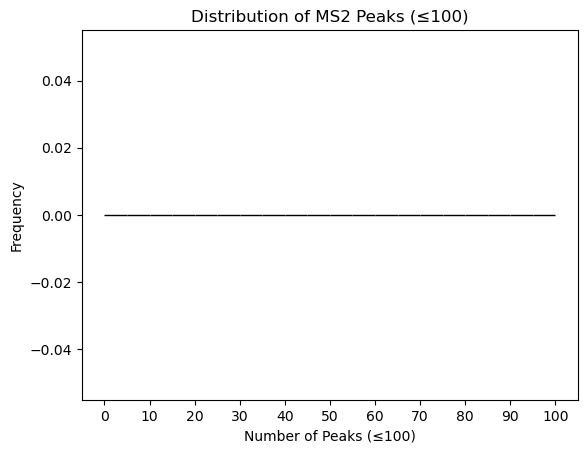

In [52]:
subset = test_set
# test_set[training_set['num_peaks'] <= 100]

# plot histogram
plt.figure()
plt.hist(subset['num_peaks'], bins=range(0, 101, 5), edgecolor='black')  # e.g. 5-peak bins
plt.xlabel('Number of Peaks (≤100)')
plt.ylabel('Frequency')
plt.title('Distribution of MS2 Peaks (≤100)')
plt.xticks(range(0, 101, 10))
plt.show()

### Ion mode

In [53]:
col = 'ion_mode'

# loop over each DataFrame by name
for df_name, df in [
    ('training_set', training_set),
    ('test_set',     test_set),
    ('test_set2',    test_set2)
]:
    if col in df.columns:
        uniques = df[col].dropna().unique()
        print(f"{df_name} has {len(uniques)} unique '{col}' values:\n{uniques}\n")
    else:
        print(f"{df_name} does NOT contain column '{col}'.\n")

training_set has 4 unique 'ion_mode' values:
['Positive' 'Negative' 'negative' 'positive']

test_set has 1 unique 'ion_mode' values:
['Positive']

test_set2 has 2 unique 'ion_mode' values:
['Positive' 'Negative']



In [54]:
training_set['ion_mode'] = (
    training_set['ion_mode']
      .astype(str)          # in case there are NaNs
      .str.lower()          
      .str.capitalize()     # 'negative' → 'Negative', 'positive' → 'Positive'
)

/var/folders/q1/mfxy01nj293b7bbnnhjkt_6w0000gn/T/ipykernel_46343/249648273.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_set['ion_mode'] = (


### Class

In [55]:
training_set['class'] = training_set['name'].str.split(' ').str[0]
test_set['class'] = test_set['name'].str.split(' ').str[0]


training_set['chain'] = training_set['name'].str.partition(' ')[2]
test_set['chain']     = test_set['name'].str.partition(' ')[2]

/var/folders/q1/mfxy01nj293b7bbnnhjkt_6w0000gn/T/ipykernel_46343/1583088241.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_set['class'] = training_set['name'].str.split(' ').str[0]
/var/folders/q1/mfxy01nj293b7bbnnhjkt_6w0000gn/T/ipykernel_46343/1583088241.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_set['chain'] = training_set['name'].str.partition(' ')[2]


In [56]:
col = 'class'

# loop over each DataFrame by name
for df_name, df in [
    ('training_set', training_set),
    ('test_set',     test_set),
]:
    if col in df.columns:
        uniques = df[col].dropna().unique()
        print(f"{df_name} has {len(uniques)} unique '{col}' values:\n{uniques}\n")
    else:
        print(f"{df_name} does NOT contain column '{col}'.\n")

training_set has 56 unique 'class' values:
['BMP' 'Cer' 'Cholesterol' 'CE' 'DG' 'DGCC' 'DGDG' 'DGTS' 'PC' 'PE' 'LPC'
 'LPE' 'FA' 'DGGA' 'GM3' 'HexCer' 'LDGCC' 'LDGTS' 'LPA' 'LPG' 'LPI' 'LPS'
 'MG' 'MGDG' 'PG' 'PI' 'PS' 'PA' 'PMeOH' 'SHexCer' 'SM' 'SQDG' 'TG'
 'GalCer' '8332519531' 'LacCer' 'DGTSA' 'PE_Cer' '1-' 'PI_Cer'
 '9384765625' 'CL' 'GlcCer' 'NAE' 'CAR' '' '18H-' '11,12-Ep-' '12-oxo-'
 '5H-' '15-oxo-' 'WE' 'LysoPE' 'PE-P' 'PC-O' 'PE-O']

test_set has 13 unique 'class' values:
['PC' 'CAR' 'LacCer' 'NAE' 'FA' 'PE' 'MG' 'TG' 'Cer' 'PC-O' 'SM' 'PS'
 '12-oxo-']



In [57]:
# drop wrong classes

drop_vals = [
    "1-",
    "18H-",
    "5H-",
    "11,12-Ep-",
    "12-oxo-",
    "15-oxo-",
    "DGTSA",
    "8332519531",
    "9384765625",
    ""
]

# Option A: overwrite each DataFrame to keep only rows NOT in drop_vals
training_set = training_set[~training_set['class'].isin(drop_vals)]
test_set     = test_set[    ~test_set['class'].isin(drop_vals)]

# Option B: drop in place by index
for df in (training_set, test_set):
    idx = df[df['class'].isin(drop_vals)].index
    df.drop(idx, inplace=True)

/var/folders/q1/mfxy01nj293b7bbnnhjkt_6w0000gn/T/ipykernel_46343/1214287626.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(idx, inplace=True)


In [58]:
training_set['class'].replace({
    'LysoPE': 'LPE',
    'Cholesterol': 'ST'
}, inplace=True)

/var/folders/q1/mfxy01nj293b7bbnnhjkt_6w0000gn/T/ipykernel_46343/1462641756.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  training_set['class'].replace({
/var/folders/q1/mfxy01nj293b7bbnnhjkt_6w0000gn/T/ipykernel_46343/1462641756.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_set['class'].replace({


In [59]:
col = 'class'

# loop over each DataFrame by name
for df_name, df in [
    ('training_set', training_set),
    ('test_set',     test_set),
]:
    if col in df.columns:
        uniques = df[col].dropna().unique()
        print(f"{df_name} has {len(uniques)} unique '{col}' values:\n{uniques}\n")
    else:
        print(f"{df_name} does NOT contain column '{col}'.\n")

training_set has 45 unique 'class' values:
['BMP' 'Cer' 'ST' 'CE' 'DG' 'DGCC' 'DGDG' 'DGTS' 'PC' 'PE' 'LPC' 'LPE'
 'FA' 'DGGA' 'GM3' 'HexCer' 'LDGCC' 'LDGTS' 'LPA' 'LPG' 'LPI' 'LPS' 'MG'
 'MGDG' 'PG' 'PI' 'PS' 'PA' 'PMeOH' 'SHexCer' 'SM' 'SQDG' 'TG' 'GalCer'
 'LacCer' 'PE_Cer' 'PI_Cer' 'CL' 'GlcCer' 'NAE' 'CAR' 'WE' 'PE-P' 'PC-O'
 'PE-O']

test_set has 12 unique 'class' values:
['PC' 'CAR' 'LacCer' 'NAE' 'FA' 'PE' 'MG' 'TG' 'Cer' 'PC-O' 'SM' 'PS']



In [60]:
a = test_set[test_set['class']=='PC-O']
a

,name,precursor_mz,adduct,ion_mode,charge,smiles,inchi,inchikey,inchikey_main,exact_mass,...,spectrum_id,ms_level,instrument,energy,num_peaks,MS2,massspecgym_id,novel,class,chain
217065,PC-O 16:1_18:1,744.591,[M+H]+,Positive,NaN,CCCCCCCCC/C=C/CCCCCCC(=O)O[C@H](COCCCCCC/C=C/C...,NaN,NaN,JAEYQNFAPYDIJI,743.583724,...,NaN,NaN,QTOF,NaN,NaN,"[[135.116714, 0.021517771373679155], [149.1350...",MassSpecGymID0395726,y,PC-O,16:1_18:1


### Chian

In [61]:
# count both _ and / together
train_both = training_set['chain'].str.count(r'[_/]').value_counts().sort_index()
test_both  = test_set   ['chain'].str.count(r'[_/]').value_counts().sort_index()

print("=== Training set total `_`+`/` counts ===")
print(train_both)
print("\n=== Test set total `_`+`/` counts ===")
print(test_both)

=== Training set total `_`+`/` counts ===
chain
0     20176
1    690219
2    248152
3       484
Name: count, dtype: int64

=== Test set total `_`+`/` counts ===
chain
0     691
1    3934
2       6
Name: count, dtype: int64


In [62]:
# this regex grabs any contiguous sequence of characters not in 0–9, underscore, colon or slash
pattern = r'[^0-9_:/]+'

unique_invalid_parts = set()

for df in (training_set, test_set):
    # iterate over each unique class string
    for cls in df['chain'].dropna().unique():
        # find all runs of invalid chars in this string
        for part in re.findall(pattern, cls):
            unique_invalid_parts.add(part)

# now print each invalid substring exactly once
for part in sorted(unique_invalid_parts):
    print(part)

 
)
-SN
;
;(
;O
;O(FA 
O
O-
OH)
P-


In [63]:
def print_rows_with_chars(df, chars):
    # escape in case chars contains regex‐special chars
    pattern = re.escape(chars)
    mask = df['chain'].str.contains(pattern, na=False)
    result = df[mask]
#     if result.empty:
#         print(f"No rows found where 'chian' contains {chars!r}")
#     else:
#         print(result)
    return result

a = print_rows_with_chars(training_set, 'P-')
a

,name,precursor_mz,adduct,ion_mode,charge,smiles,inchi,inchikey,inchikey_main,exact_mass,...,lib_quality,source,spectrum_id,ms_level,instrument,energy,num_peaks,MS2,class,chain
912966,PE P-16:0/18:3,698.512,[M+H]+,Positive,1.0,NaN,NaN,NaN,NaN,NaN,...,1.0,PNNL-Lipids,CCMSLIB00010056354,2.0,LC-ESI-CID; Velos,NaN,131,"[[156.978317, 4.616386], [173.076004, 26.85183...",PE,P-16:0/18:3
912967,PE P-16:0/18:3,698.512,[M+H]+,Positive,1.0,NaN,NaN,NaN,NaN,NaN,...,1.0,PNNL-Lipids,CCMSLIB00010056355,2.0,LC-ESI-HCD; Velos,NaN,41,"[[95.08535, 259.385345], [105.899651, 81.08142...",PE,P-16:0/18:3
912968,PE P-16:0/20:5,722.512,[M+H]+,Positive,1.0,NaN,NaN,NaN,NaN,NaN,...,1.0,PNNL-Lipids,CCMSLIB00010056356,2.0,LC-ESI-CID; Velos,NaN,217,"[[135.029633, 7.093425], [147.087296, 4.07479]...",PE,P-16:0/20:5
912969,PE P-16:0/20:5,722.512,[M+H]+,Positive,1.0,NaN,NaN,NaN,NaN,NaN,...,1.0,PNNL-Lipids,CCMSLIB00010056357,2.0,LC-ESI-HCD; Velos,NaN,64,"[[92.798004, 106.40403], [93.06958, 471.502258...",PE,P-16:0/20:5
913030,PE P-16:0/20:5,722.512,[M+H]+,Positive,1.0,NaN,NaN,NaN,NaN,NaN,...,1.0,PNNL-Lipids,CCMSLIB00010056418,2.0,LC-ESI-CID; Velos,NaN,147,"[[135.097351, 4.434865], [146.987579, 27.19928...",PE,P-16:0/20:5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
959540,PE P-16:0_22:6,746.511,[M-H]-,Negative,1.0,[H][C@@](CO\C=C/CCCCCCCCCCCCCC)(COP(O)(=O)OCCN...,NaN,NaN,WVGALBKSWOUIEZ,747.520290,...,3.0,HCE,CCMSLIB00005720966,2.0,LC-ESI-qTof,NaN,716,"[[101.854378, 18.92128], [105.067558, 107.0], ...",PE,P-16:0_22:6
959542,PE P-18:0_20:4,750.543,[M-H]-,Negative,1.0,[H][C@@](CO\C=C/CCCCCCCCCCCCCCCC)(COP(O)(=O)OC...,NaN,NaN,URPXXNCTXCOATD,751.551590,...,3.0,HCE,CCMSLIB00005720969,2.0,LC-ESI-qTof,NaN,649,"[[103.07785, 17.0], [105.070045, 15.877998], [...",PE,P-18:0_20:4
959543,PE P-18:0_20:3,752.557,[M-H]-,Negative,1.0,[H][C@@](CO\C=C/CCCCCCCCCCCCCCCC)(COP(O)(=O)OC...,NaN,NaN,CPDVNQFVCLXOCQ,753.567241,...,3.0,HCE,CCMSLIB00005720970,2.0,LC-ESI-qTof,NaN,361,"[[104.348457, 11.614418], [127.070702, 17.0], ...",PE,P-18:0_20:3
959548,PE P-18:1_22:6,772.527,[M-H]-,Negative,1.0,[H][C@@](CO\C=C/CCCCCC\C=C/CCCCCCCC)(COP(O)(=O...,NaN,NaN,UKPNUUDYLNCIOE,773.535940,...,3.0,HCE,CCMSLIB00005720981,2.0,LC-ESI-qTof,NaN,417,"[[105.071388, 35.329407], [105.077629, 28.1450...",PE,P-18:1_22:6


#### For O- or P-, add to Class
P-:  
O-:   
#### For SN, drop it

In [64]:
def adjust_chain_and_class(df):
    """
    For rows where 'chain' contains 'P-' or 'O-':
    - Remove all occurrences of 'P-' or 'O-' from 'chain'
    - Append '-P' or '-O' to the 'class' column
    """
    # Handle 'P-' anywhere in chain
    mask_p = df['chain'].str.contains('P-')
    df.loc[mask_p, 'class'] = df.loc[mask_p, 'class'].astype(str) + '-P'
    df.loc[mask_p, 'chain'] = df.loc[mask_p, 'chain'].str.replace(r'P-', '', regex=True)

    # Handle 'O-' anywhere in chain
    mask_o = df['chain'].str.contains('O-')
    df.loc[mask_o, 'class'] = df.loc[mask_o, 'class'].astype(str) + '-O'
    df.loc[mask_o, 'chain'] = df.loc[mask_o, 'chain'].str.replace(r'O-', '', regex=True)

    return df


# Apply to both dataframes
test_set = adjust_chain_and_class(test_set)
training_set = adjust_chain_and_class(training_set)

In [65]:
training_set['chain'] = training_set['chain'].str.replace(r'-SN\d+', '', regex=True)

/var/folders/q1/mfxy01nj293b7bbnnhjkt_6w0000gn/T/ipykernel_46343/3627731246.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_set['chain'] = training_set['chain'].str.replace(r'-SN\d+', '', regex=True)


In [66]:
col = 'class'

# loop over each DataFrame by name
for df_name, df in [
    ('training_set', training_set),
    ('test_set',     test_set),
]:
    if col in df.columns:
        uniques = df[col].dropna().unique()
        print(f"{df_name} has {len(uniques)} unique '{col}' values:\n{uniques}\n")
    else:
        print(f"{df_name} does NOT contain column '{col}'.\n")

training_set has 50 unique 'class' values:
['BMP' 'Cer' 'ST' 'CE' 'DG' 'DGCC' 'DGDG' 'DGTS' 'PC-O' 'PE-O' 'LPC-O'
 'LPE-O' 'FA' 'DGGA' 'GM3' 'HexCer' 'LDGCC' 'LDGTS' 'LPA' 'LPC' 'LPE'
 'LPG' 'LPI' 'LPS' 'MG' 'MGDG' 'PC' 'PE' 'PG' 'PI' 'PS' 'PA' 'PMeOH'
 'SHexCer' 'SM' 'SQDG' 'TG' 'GalCer' 'PE-P' 'PC-P' 'LacCer' 'PE_Cer'
 'PI_Cer' 'PG-O' 'CL' 'PG-P' 'GlcCer' 'NAE' 'CAR' 'WE']

test_set has 15 unique 'class' values:
['PC' 'CAR' 'LacCer' 'NAE' 'FA' 'PE' 'MG-O' 'TG' 'Cer' 'PC-O' 'SM' 'PS'
 'PC-P' 'MG' 'PE-P']



In [67]:
# this regex grabs any contiguous sequence of characters not in 0–9, underscore, colon or slash
pattern = r'[^0-9_:/]+'

unique_invalid_parts = set()

for df in (training_set, test_set):
    # iterate over each unique class string
    for cls in df['chain'].dropna().unique():
        # find all runs of invalid chars in this string
        for part in re.findall(pattern, cls):
            unique_invalid_parts.add(part)

# now print each invalid substring exactly once
for part in sorted(unique_invalid_parts):
    print(part)

 
)
;
;(
;O
;O(FA 
O
OH)


In [68]:
a = print_rows_with_chars(training_set, '')
a

,name,precursor_mz,adduct,ion_mode,charge,smiles,inchi,inchikey,inchikey_main,exact_mass,...,lib_quality,source,spectrum_id,ms_level,instrument,energy,num_peaks,MS2,class,chain
102,BMP 2:0_2:0,348.10541,[M+NH4]+,Positive,NaN,CC(=O)OC(CO)COP(O)(=O)OCC(CO)OC(C)=O,NaN,XEESPTCVRVGWGZ-UHFFFAOYNA-N,XEESPTCVRVGWGZ,330.071583,...,NaN,MS-DIAL,NaN,NaN,NaN,NaN,3,"[[117.0546, 1998], [159.0663, 50], [348.1054, ...",BMP,2:0_2:0
103,BMP 2:0_3:0,362.12106,[M+NH4]+,Positive,NaN,CCC(=O)OC(CO)COP(O)(=O)OCC(CO)OC(C)=O,NaN,DKAMTBKCFXFXRH-UHFFFAOYNA-N,DKAMTBKCFXFXRH,344.087234,...,NaN,MS-DIAL,NaN,NaN,NaN,NaN,4,"[[117.0546, 999], [131.0703, 999], [173.0819, ...",BMP,2:0_3:0
104,BMP 2:0_4:0,376.13671,[M+NH4]+,Positive,NaN,CCCC(=O)OC(CO)COP(O)(=O)OCC(CO)OC(C)=O,NaN,TVHIQWVSTDVIDG-UHFFFAOYNA-N,TVHIQWVSTDVIDG,358.102884,...,NaN,MS-DIAL,NaN,NaN,NaN,NaN,4,"[[117.0546, 999], [145.0859, 999], [187.0976, ...",BMP,2:0_4:0
105,BMP 2:0_5:0,390.15236,[M+NH4]+,Positive,NaN,CCCCC(=O)OC(CO)COP(O)(=O)OCC(CO)OC(C)=O,NaN,GHBVTXXMBOFKBZ-UHFFFAOYNA-N,GHBVTXXMBOFKBZ,372.118534,...,NaN,MS-DIAL,NaN,NaN,NaN,NaN,4,"[[117.0546, 999], [159.1016, 999], [201.1132, ...",BMP,2:0_5:0
106,BMP 2:0_6:0,404.16801,[M+NH4]+,Positive,NaN,CCCCCC(=O)OC(CO)COP(O)(=O)OCC(CO)OC(C)=O,NaN,ZRHUBPLHUGJTHF-UHFFFAOYNA-N,ZRHUBPLHUGJTHF,386.134184,...,NaN,MS-DIAL,NaN,NaN,NaN,NaN,4,"[[117.0546, 999], [173.1172, 999], [215.1289, ...",BMP,2:0_6:0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
959717,PS 18:0_16:1,760.51200,[M-H]-,Negative,1.0,[H][C@](N)(COP(O)(=O)OC[C@@]([H])(COC(=O)CCCCC...,NaN,NaN,BWQAJZLCZFRDSD,761.520684,...,3.0,IOBA-NHC,CCMSLIB00005724255,2.0,LC-ESI-qTof,NaN,36,"[[152.993195, 59.0], [153.990814, 19.0], [252....",PS,18:0_16:1
959718,PS 18:0_22:5,836.54200,[M-H]-,Negative,1.0,[H][C@](N)(COP(O)(=O)OC[C@@]([H])(COC(=O)CCCCC...,NaN,NaN,KMPUODCMAGXMDR,837.551984,...,3.0,IOBA-NHC,CCMSLIB00005724256,2.0,LC-ESI-qTof,NaN,53,"[[108.166229, 17.0], [152.996857, 103.912659],...",PS,18:0_22:5
959719,PS 18:1_18:1,786.52700,[M-H]-,Negative,1.0,[H][C@](N)(COP(O)(=O)OC[C@@]([H])(COC(=O)CCCCC...,NaN,NaN,AFRDXDOQWNVNPX,787.536334,...,3.0,IOBA-NHC,CCMSLIB00005724257,2.0,LC-ESI-qTof,NaN,29,"[[152.989365, 51.677917], [153.000549, 101.095...",PS,18:1_18:1
959720,PS 18:1_22:0,844.60800,[M-H]-,Negative,1.0,[H][C@](N)(COP(O)(=O)OC[C@@]([H])(COC(=O)CCCCC...,NaN,NaN,KKIWTFIITJYWJK,845.614585,...,3.0,IOBA-NHC,CCMSLIB00005724258,2.0,LC-ESI-qTof,NaN,59,"[[152.990509, 32.832367], [153.005264, 23.9671...",PS,18:1_22:0


### Sub Chain

In [69]:
def parse_chain(chain: str) -> dict:
    parts = re.split(r"[_/]", chain)
    result = {}
    for i in range(4):
        seg = parts[i] if i < len(parts) else ""
        result[f'c{i+1}'] = seg
        if not seg:
            result[f'num_c_{i+1}'] = 0
            result[f'num_db_{i+1}'] = 0
            result[f'extra_{i+1}'] = None
            continue

        if ':' in seg:
            num_c = seg.split(':', 1)[0]
        elif ';' in seg:
            num_c = seg.split(';', 1)[0]
        else:
            num_c = seg
        result[f'num_c_{i+1}'] = num_c

        if ':' in seg:
            after_colon = seg.split(':', 1)[1]
            num_db = after_colon.split(';', 1)[0]
        else:
            num_db = 0
        result[f'num_db_{i+1}'] = num_db

        if ';' in seg:
            extra = seg.split(';', 1)[1]
        else:
            extra = 'NA'
        result[f'extra_{i+1}'] = extra

    return result



training_set = training_set.join(training_set['chain'].apply(parse_chain).apply(pd.Series))
test_set = test_set.join(test_set['chain'].apply(parse_chain).apply(pd.Series))

In [70]:
columns_to_drop = ['c1', 'c2', 'c3', 'c4']

# Drop columns from both dataframes
training_set = training_set.drop(columns=columns_to_drop, errors='ignore')
test_set = test_set.drop(columns=columns_to_drop, errors='ignore')

In [71]:
def count_extras(df, dataset_name="dataset"):
    # 筛选所有extra相关的列
    extra_cols = [col for col in df.columns if col.startswith('extra_')]

    # 取出所有extra列，拉平成一列
    extras = pd.concat([df[col] for col in extra_cols])

    # 统计每个unique值出现的次数
    freq = extras.value_counts()

    # 打印结果
    print(f"\nFor {dataset_name}:")
    for value, count in freq.items():
        print(f"- {value}: {count}")

# 调用函数
count_extras(training_set, dataset_name="training_set")
count_extras(test_set, dataset_name="test_set")


For training_set:
- NA: 1385625
- 2O: 431419
- (2OH): 71484
- 3O: 68091
- (3OH): 14076
- O(FA 22:2): 7038
- O(FA 22:1): 7038
- O(FA 22:0): 7038
- O(FA 19:0): 7038
- O(FA 21:1): 7038
- O(FA 21:0): 7038
- O(FA 20:2): 7038
- O(FA 20:1): 7038
- O(FA 20:0): 7038
- O(FA 19:2): 7038
- O(FA 19:1): 7038
- O(FA 21:2): 7038
- O(FA 18:1): 7038
- O(FA 18:2): 7038
- O(FA 18:0): 7038
- O(FA 17:2): 7038
- O(FA 17:1): 7038
- O(FA 17:0): 7038
- O(FA 16:2): 7038
- O(FA 16:1): 7038
- O(FA 16:0): 7038
- O(FA 15:1): 7038
- O(FA 15:0): 7038
- O(FA 14:1): 7038
- O(FA 14:0): 7038
- O: 269
- 4O: 90

For test_set:
- NA: 8577


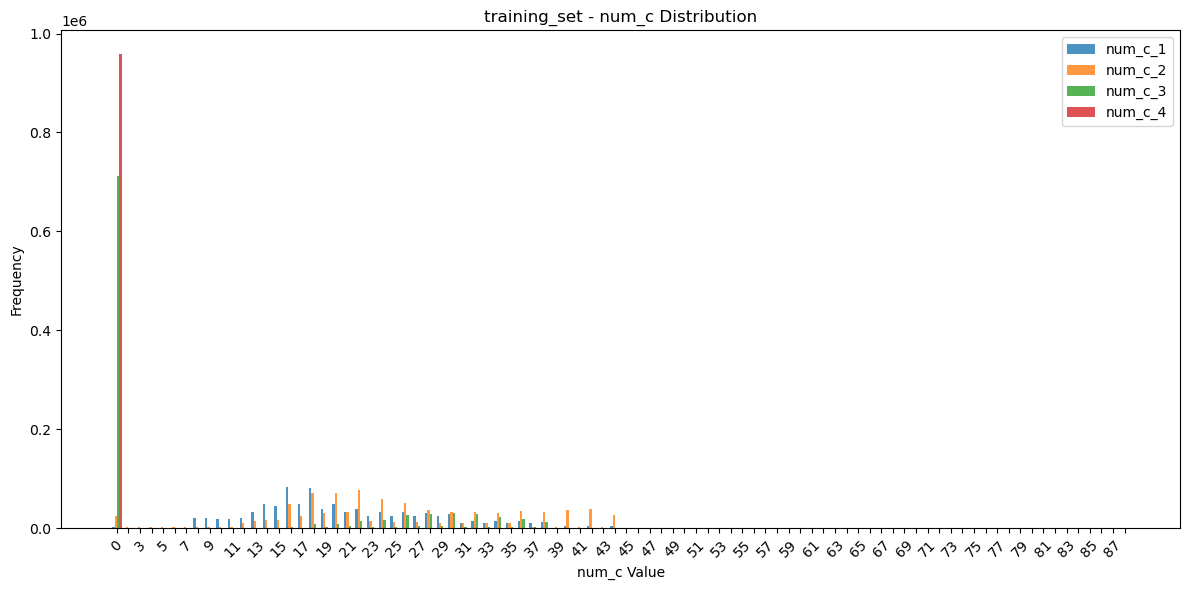

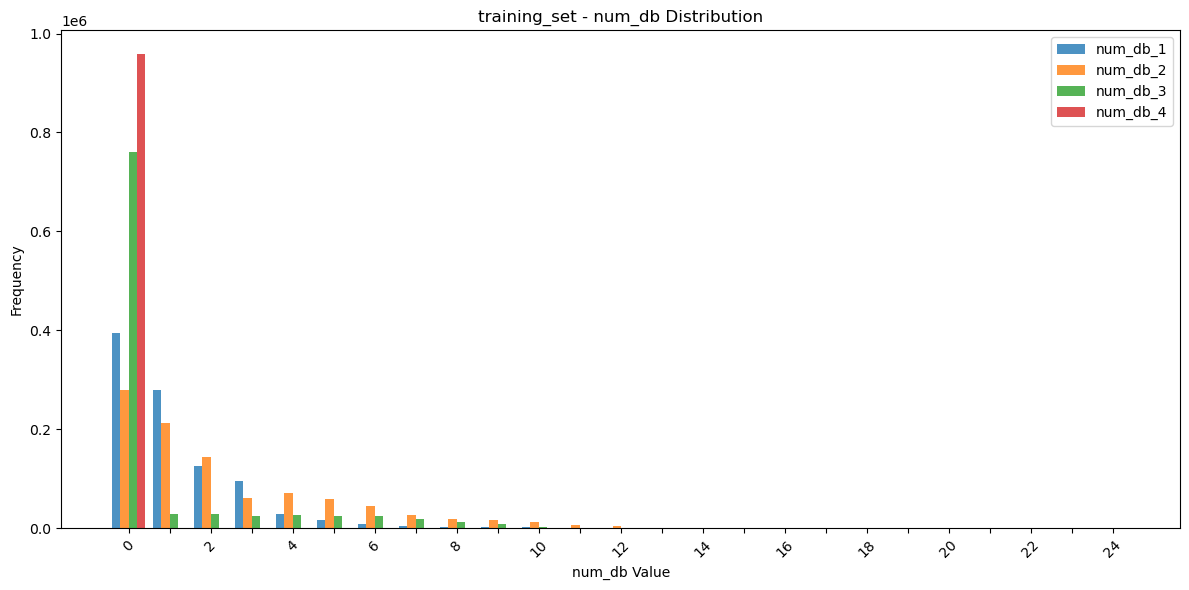

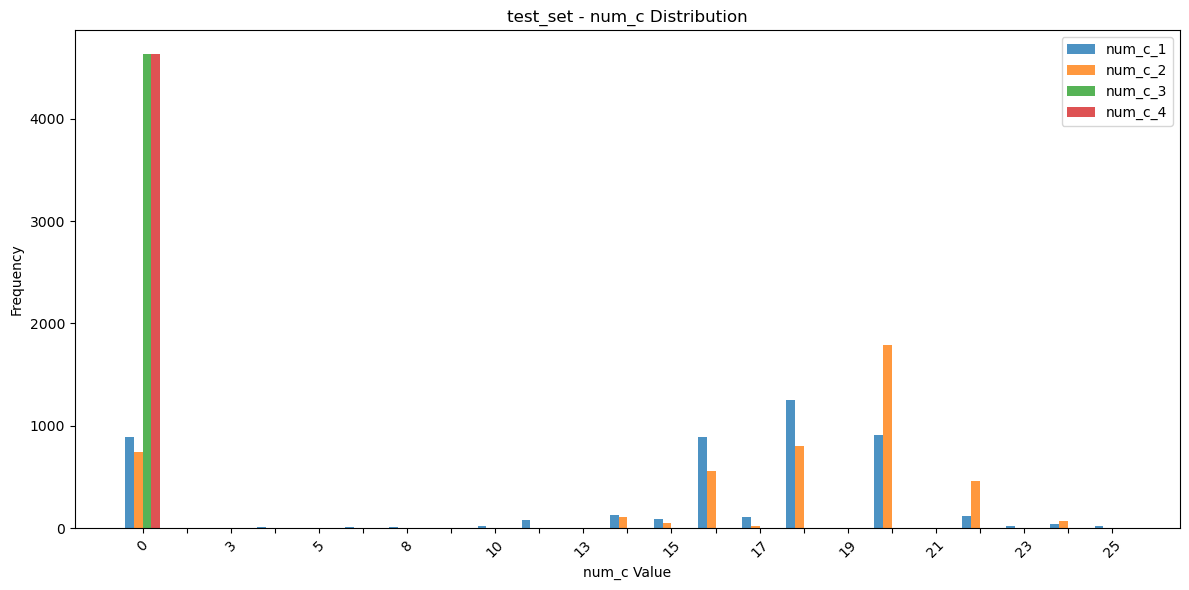

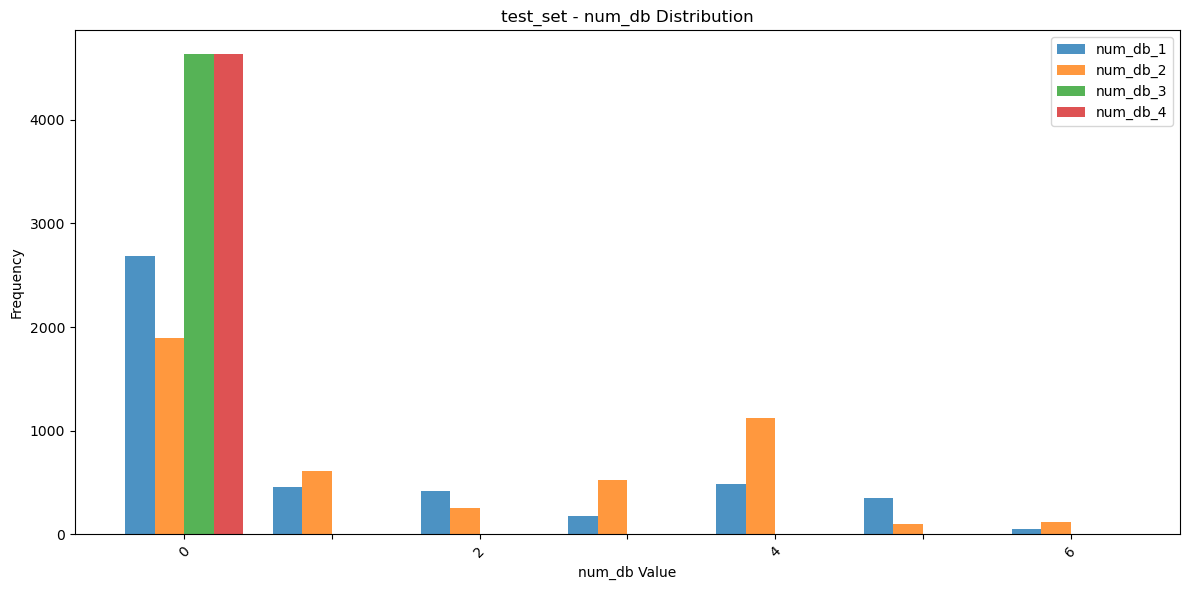

In [72]:
def plot_num_distribution(df, dataset_name="dataset"):
    # 提取 num_c 和 num_db 列
    num_c_cols = [col for col in df.columns if col.startswith('num_c_')]
    num_db_cols = [col for col in df.columns if col.startswith('num_db_')]

    # ------------------ Plot num_c ------------------
    plt.figure(figsize=(12, 6))
    
    # 汇总所有num_c列的值和频率
    counts_c = {}
    for col in num_c_cols:
        temp = df[col].dropna().astype(int).value_counts()
        for k, v in temp.items():
            if k not in counts_c:
                counts_c[k] = {}
            counts_c[k][col] = v

    keys_sorted = sorted(counts_c.keys())

    bar_width = 0.2
    x = np.arange(len(keys_sorted))

    for idx, col in enumerate(num_c_cols):
        y = [counts_c.get(k, {}).get(col, 0) for k in keys_sorted]
        plt.bar(x + idx * bar_width, y, width=bar_width, label=col, alpha=0.8)

    plt.title(f"{dataset_name} - num_c Distribution")
    plt.xlabel("num_c Value")
    plt.ylabel("Frequency")
    plt.xticks(x + bar_width * 1.5, keys_sorted, rotation=45)

    # 隔一个标一个，避免label太密集
    ax = plt.gca()
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % 2 != 0:
            label.set_visible(False)

    plt.legend()
    plt.tight_layout()
    plt.show()

    # ------------------ Plot num_db ------------------
    plt.figure(figsize=(12, 6))
    
    counts_db = {}
    for col in num_db_cols:
        temp = df[col].dropna().astype(int).value_counts()
        for k, v in temp.items():
            if k not in counts_db:
                counts_db[k] = {}
            counts_db[k][col] = v

    keys_sorted = sorted(counts_db.keys())
    x = np.arange(len(keys_sorted))

    for idx, col in enumerate(num_db_cols):
        y = [counts_db.get(k, {}).get(col, 0) for k in keys_sorted]
        plt.bar(x + idx * bar_width, y, width=bar_width, label=col, alpha=0.8)

    plt.title(f"{dataset_name} - num_db Distribution")
    plt.xlabel("num_db Value")
    plt.ylabel("Frequency")
    plt.xticks(x + bar_width * 1.5, keys_sorted, rotation=45)

    ax = plt.gca()
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % 2 != 0:
            label.set_visible(False)

    plt.legend()
    plt.tight_layout()
    plt.show()

# 调用绘图函数
plot_num_distribution(training_set, dataset_name="training_set")
plot_num_distribution(test_set, dataset_name="test_set")

In [73]:
def get_num_frequency_table(df):
    # 筛选 num_c 和 num_db 列
    target_cols = [col for col in df.columns if col.startswith('num_c_') or col.startswith('num_db_')]

    rows = []

    for col in target_cols:
        # 统计每个值的频数
        counts = df[col].dropna().astype(int).value_counts()
        for value, freq in counts.items():
            rows.append((col, value, freq))

    # 转成DataFrame
    freq_table = pd.DataFrame(rows, columns=['column', 'value', 'frequency'])

    return freq_table

freq_table_training = get_num_frequency_table(training_set)
freq_table_test = get_num_frequency_table(test_set)

In [75]:
test_set.columns

Index(['name', 'precursor_mz', 'adduct', 'ion_mode', 'charge', 'smiles',
       'inchi', 'inchikey', 'inchikey_main', 'exact_mass', 'formula',
       'synonyms', 'retention_time', 'lib_quality', 'source', 'spectrum_id',
       'ms_level', 'instrument', 'energy', 'num_peaks', 'MS2',
       'massspecgym_id', 'novel', 'class', 'chain', 'num_c_1', 'num_db_1',
       'extra_1', 'num_c_2', 'num_db_2', 'extra_2', 'num_c_3', 'num_db_3',
       'extra_3', 'num_c_4', 'num_db_4', 'extra_4'],
      dtype='object')

### One Chain Name

In [76]:
db_cols = ['num_db_1', 'num_db_2', 'num_db_3', 'num_db_4']
c_cols = ['num_c_1', 'num_c_2', 'num_c_3', 'num_c_4']

# Ensure all C and DB columns are numeric integers
def convert_to_int(df, cols):
    for col in cols:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

for df in (training_set, test_set):
    convert_to_int(df, c_cols + db_cols)

# Create the 'simple_name' column for each DataFrame
for df in (training_set, test_set):
    # Sum C columns for A
    sum_c = df[c_cols].sum(axis=1)
    # Sum DB columns for B
    sum_db = df[db_cols].sum(axis=1)
    # Combine into 'A:B' string
    df['simple_name'] = df['class'].astype(str) + ' ' + sum_c.astype(str) + ':' + sum_db.astype(str)

### Reletive MS2

In [79]:
def clean_ms2_series(ms2_series: pd.Series) -> list:
    """
    Processes a Pandas Series of MS2 entries, ensuring each entry is
    a list of [mz, intensity] pairs (floats), normalized, and limited.

    - Parses string-encoded lists.
    - Converts flat numeric lists into pairs.
    - Validates list-of-pair formats.
    - Normalizes intensities so the maximum is 100.
    - Retains only the 100 highest-intensity pairs if more are present.
    Stops processing and prints any entry that fails conversion.

    Returns:
        List of processed MS2 entries up to any failure.
    """
    cleaned = []

    for idx, entry in ms2_series.items():
        original = entry

        # Parse string representations
        if isinstance(entry, str):
            try:
                entry = ast.literal_eval(entry)
            except Exception:
                print(f"Failed to parse entry at index {idx}: {original}")
                break

        # Determine raw pairs
        if isinstance(entry, list) and entry and all(isinstance(x, (int, float)) for x in entry):
            # Flat list -> group into pairs
            if len(entry) % 2 != 0:
                print(f"Odd-length flat list at index {idx}: {entry}")
                break
            pairs = [[float(entry[i]), float(entry[i+1])] for i in range(0, len(entry), 2)]

        elif isinstance(entry, list) and all(isinstance(sub, (list, tuple)) and len(sub) == 2 for sub in entry):
            # Already pairs -> validate numeric and convert
            valid = True
            pairs = []
            for sub in entry:
                mz, intensity = sub
                if not isinstance(mz, (int, float)) or not isinstance(intensity, (int, float)):
                    valid = False
                    break
                pairs.append([float(mz), float(intensity)])
            if not valid:
                print(f"Non-numeric sublist at index {idx}: {entry}")
                break

        else:
            # Unrecognized format
            print(f"Unrecognized format at index {idx}: {original}")
            break

        # Normalize intensities: scale so max = 100
        if pairs:
            max_intensity = max(intensity for _, intensity in pairs)
            if max_intensity > 0:
                pairs = [[mz, intensity / max_intensity * 100] for mz, intensity in pairs]
            else:
                # All intensities zero
                pairs = [[mz, 0.0] for mz, _ in pairs]

        # Limit to top 100 by intensity
        if len(pairs) > 100:
            pairs = sorted(pairs, key=lambda x: x[1], reverse=True)[:100]

        cleaned.append(pairs)

    return cleaned


In [80]:
training_set['MS2_norm'] = clean_ms2_series(training_set['MS2'])
test_set['MS2_norm'] = clean_ms2_series(test_set['MS2'])
test_set2['MS2_norm'] = clean_ms2_series(test_set2['MS2'])

In [93]:
print(training_set.shape, test_set.shape, test_set2.shape)

(959031, 37) (4631, 39) (58, 22)


# Order

In [95]:
test_set = test_set.rename(columns={'massspecgym_id': 'spectrum_id'})

In [96]:
training_set.columns

Index(['name', 'simple_name', 'class', 'chain', 'num_c_1', 'num_db_1',
       'extra_1', 'num_c_2', 'num_db_2', 'extra_2', 'num_c_3', 'num_db_3',
       'extra_3', 'num_c_4', 'num_db_4', 'extra_4', 'precursor_mz', 'adduct',
       'ion_mode', 'charge', 'smiles', 'inchi', 'inchikey', 'inchikey_main',
       'exact_mass', 'formula', 'synonyms', 'retention_time', 'lib_quality',
       'source', 'spectrum_id', 'ms_level', 'instrument', 'energy',
       'num_peaks', 'MS2', 'MS2_norm'],
      dtype='object')

In [97]:
# Define the desired column order
desired_order = [
    'name', 'simple_name', 'class', 'chain',
    'num_c_1', 'num_db_1', 'extra_1',
    'num_c_2', 'num_db_2', 'extra_2',
    'num_c_3', 'num_db_3', 'extra_3',
    'num_c_4', 'num_db_4', 'extra_4',
    'precursor_mz', 'adduct', 'ion_mode', 'charge',
    'smiles', 'inchi', 'inchikey', 'inchikey_main',
    'exact_mass', 'formula', 'synonyms',
    'retention_time', 'lib_quality', 'source',
    'spectrum_id', 'ms_level', 'instrument',
    'energy', 'num_peaks', 'MS2', 'MS2_norm'
]

# Names of the DataFrames to process
df_names = ['training_set', 'test_set', 'test_set2']

for name in df_names:
    df = globals().get(name, None)
    if df is None:
        print(f"No DataFrame named '{name}' found.")
        continue
    
    cols = df.columns.tolist()
    missing = [c for c in desired_order if c not in cols]
    extra = [c for c in cols if c not in desired_order]
    
    if missing:
        print(f"{name} is missing columns: {missing}")
    if extra:
        print(f"{name} has extra columns: {extra}")
    
    # Build the new column order
    new_order = [c for c in desired_order if c in cols] + extra
    
    # Reassign the reordered DataFrame back to the original name
    globals()[name] = df[new_order]

print("Column reordering complete.")

test_set has extra columns: ['novel']
test_set2 is missing columns: ['simple_name', 'class', 'chain', 'num_c_1', 'num_db_1', 'extra_1', 'num_c_2', 'num_db_2', 'extra_2', 'num_c_3', 'num_db_3', 'extra_3', 'num_c_4', 'num_db_4', 'extra_4']
Column reordering complete.


In [98]:
training_set.to_csv('processed_ds_0427/trainning_set.csv', index=False)
test_set.to_csv('processed_ds_0427/test_set.csv', index=False)
test_set2.to_csv('processed_ds_0427/test_set2.csv', index=False)

In [99]:
print(training_set.shape, test_set.shape, test_set[test_set['novel']=='y'].shape, test_set2.shape)

(959031, 37) (4631, 39) (1372, 39) (58, 22)


************

# 5. Data Analysis

### Adduct

/var/folders/q1/mfxy01nj293b7bbnnhjkt_6w0000gn/T/ipykernel_46343/3541053948.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='adduct', data=training_set, ax=axes[0], palette="mako")
/var/folders/q1/mfxy01nj293b7bbnnhjkt_6w0000gn/T/ipykernel_46343/3541053948.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='adduct', data=test_set, ax=axes[1], palette="rocket")


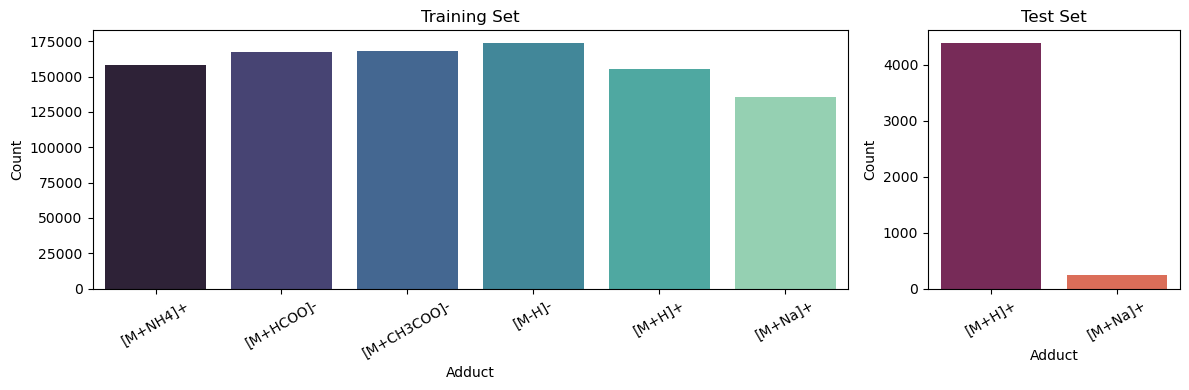

Training Set Frequency Count:
adduct
[M-H]-         174065
[M+CH3COO]-    167823
[M+HCOO]-      167760
[M+NH4]+       157905
[M+H]+         155721
[M+Na]+        135757
Name: count, dtype: int64

Test Set Frequency Count:
adduct
[M+H]+     4394
[M+Na]+     237
Name: count, dtype: int64


In [82]:
# Adduct

# Create a figure with 2 subplots and adjust the left subplot's width to be larger than the right one
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4),
                         gridspec_kw={'width_ratios': [3, 1]})

# Countplot for the training set using the "mako" palette
sns.countplot(x='adduct', data=training_set, ax=axes[0], palette="mako")
axes[0].set_title("Training Set")
axes[0].set_xlabel("Adduct")
axes[0].set_ylabel("Count")
plt.setp(axes[0].get_xticklabels(), rotation=30)

# Countplot for the test set using the "rocket" palette
sns.countplot(x='adduct', data=test_set, ax=axes[1], palette="rocket")
axes[1].set_title("Test Set")
axes[1].set_xlabel("Adduct")
axes[1].set_ylabel("Count")
plt.setp(axes[1].get_xticklabels(), rotation=30)

# Adjust the layout for a neat display and show the plots
plt.tight_layout()
plt.show()

# Print frequency counts for the "adduct" column in the training set
print("Training Set Frequency Count:")
print(training_set['adduct'].value_counts())

# Print frequency counts for the "adduct" column in the test set
print("\nTest Set Frequency Count:")
print(test_set['adduct'].value_counts())

### Instrument

In [50]:
# !!! The major dataset MS-DIAL no this kind of information

# # Instrument

# # Optional: Set the overall color palette to 'mako'
# sns.set_palette("Paired")

# # Create a figure for the plot
# plt.figure(figsize=(10, 6))

# # Create the count plot for the 'intrument' column using the 'mako' palette
# sns.countplot(x=training_set['instrument'], palette="Paired")

# # Add plot title and axis labels
# plt.title("Distribution of 'intrument' Values")
# plt.xlabel("Intrument")
# plt.ylabel("Count")

# # Rotate x-axis labels if necessary for better readability
# plt.xticks(rotation=45)

# # Display the plot
# plt.show()

### Mass

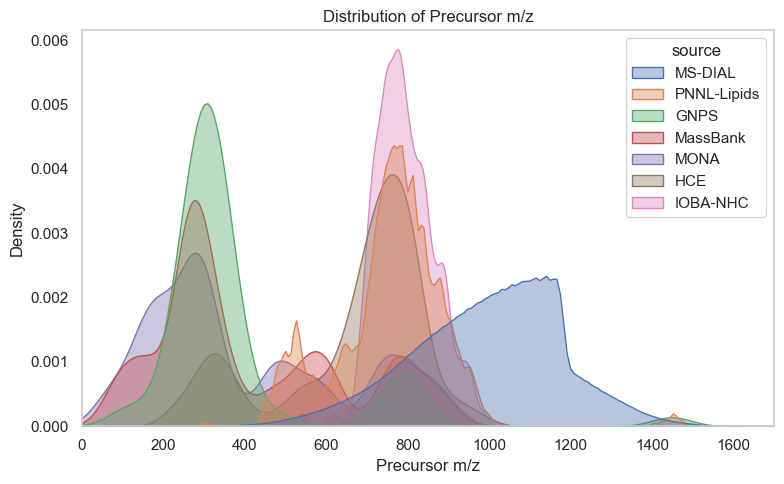

In [83]:
# Set a Seaborn style/theme (optional)
sns.set_theme(style='whitegrid')

plt.figure(figsize=(8, 5))

# Create an overlapping KDE plot (kernel density estimate)
sns.kdeplot(
    data=training_set,
    x="precursor_mz",
    hue="source",
    fill=True,        # fill under each KDE curve
    alpha=0.4,        # transparency for overlap
    common_norm=False, # if you want each distribution normalized separately
    bw_adjust=0.5      # reduce the bandwidth to make the "block" smaller
)

# Optional customizations
plt.title('Distribution of Precursor m/z')
plt.xlabel('Precursor m/z')
plt.ylabel('Density')
plt.grid(False)
plt.xlim(0, 1700)

plt.tight_layout()
plt.show()

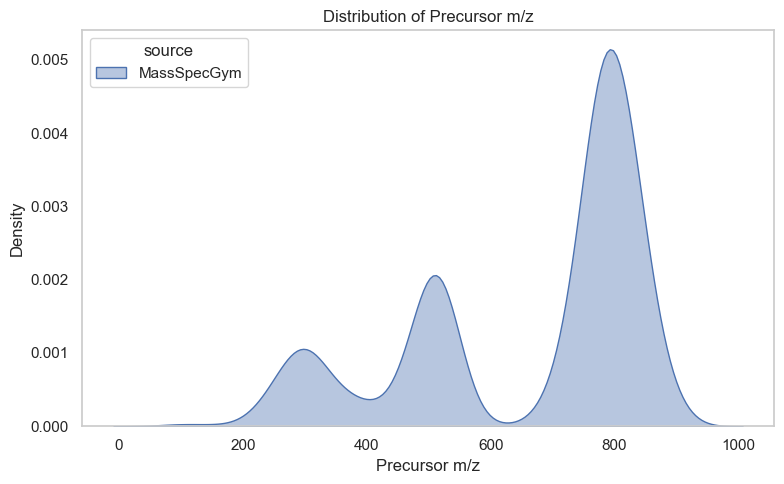

In [84]:
sns.set_theme(style='whitegrid')

plt.figure(figsize=(8, 5))

# Create an overlapping KDE plot (kernel density estimate)
sns.kdeplot(
    data=test_set,
    x="precursor_mz",
    hue="source",
    fill=True,        # fill under each KDE curve
    alpha=0.4,        # transparency for overlap
    common_norm=False # if you want each distribution normalized separately
)

# Optional customizations
plt.title('Distribution of Precursor m/z')
plt.xlabel('Precursor m/z')
plt.ylabel('Density')
plt.grid(False)

plt.tight_layout()
plt.show()

### Class

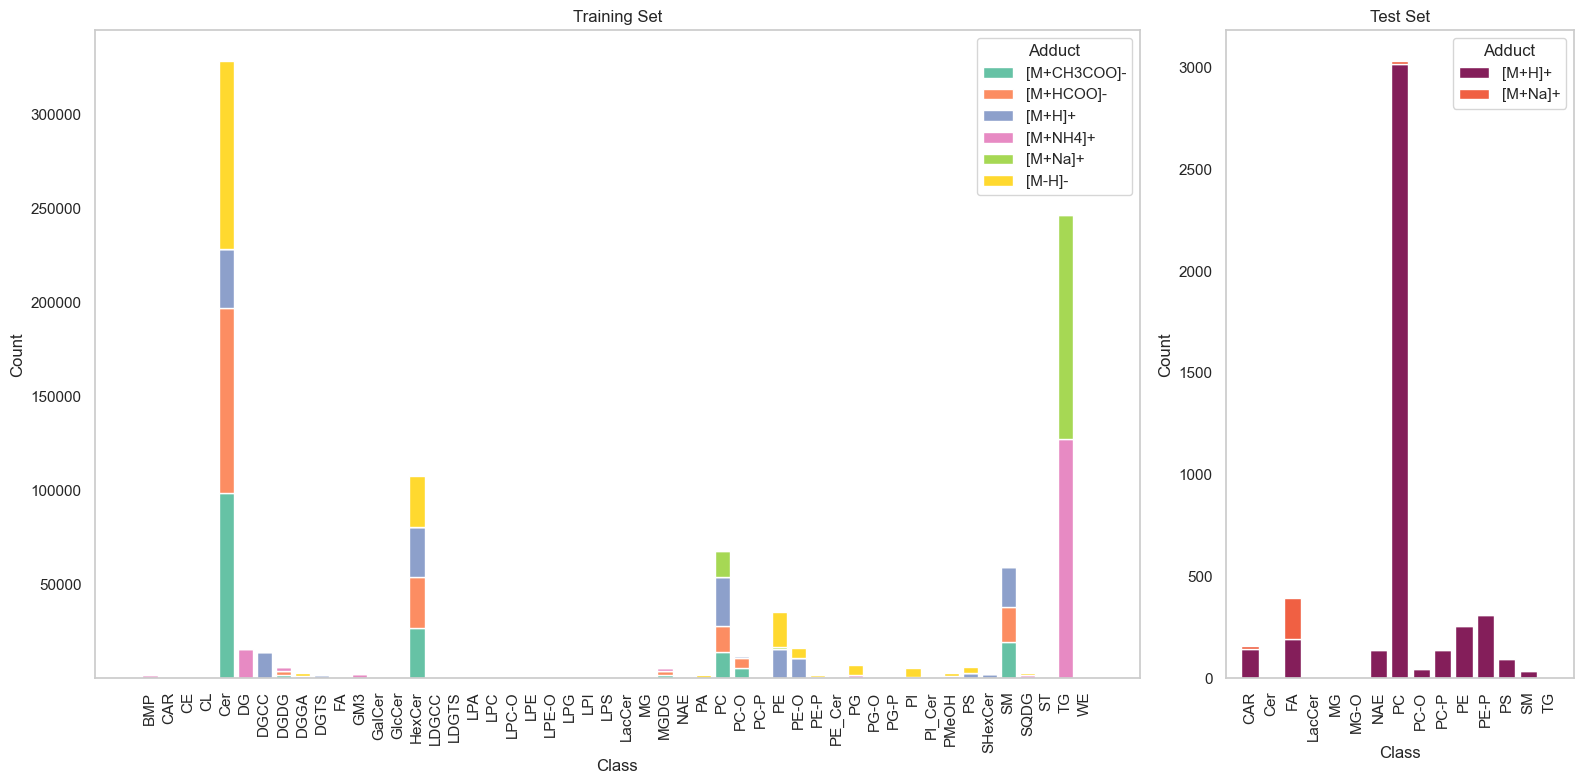

In [85]:
# train_counts = training_set.groupby(['class', 'adduct']).size().unstack(fill_value=0)
# test_counts = test_set.groupby(['class', 'adduct']).size().unstack(fill_value=0)

# # Get the unique adduct categories based on the pivot tables columns
# adduct_categories_train = train_counts.columns.tolist()
# adduct_categories_test = test_counts.columns.tolist()

# # Define color palettes for each dataset based on the number of unique adduct values
# train_palette = sns.color_palette("Set2", n_colors=len(adduct_categories_train))
# test_palette = sns.color_palette("rocket", n_colors=len(adduct_categories_test))

# # Map each adduct value to a color from the corresponding palette
# color_map_train = dict(zip(adduct_categories_train, train_palette))
# color_map_test = dict(zip(adduct_categories_test, test_palette))

# # Create a figure with 2 subplots with customized width ratios
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 8),
#                          gridspec_kw={'width_ratios': [3, 1]})
# plt.grid(False)

# # --------------------------
# # Plot for the Training Set
# # --------------------------
# classes_train = train_counts.index.tolist()
# bottom = np.zeros(len(classes_train))  # used to stack the bars

# # Plot each adduct segment as a bar atop the previous segments
# for adduct in adduct_categories_train:
#     values = train_counts[adduct].values
#     axes[0].bar(classes_train, values, bottom=bottom,
#                 label=adduct, color=color_map_train[adduct])
#     bottom += values

# axes[0].set_title("Training Set")
# axes[0].set_xlabel("Class")
# axes[0].set_ylabel("Count")
# axes[0].tick_params(axis='x', rotation=30)
# axes[0].legend(title='Adduct')
# axes[0].grid(False)


# # --------------------------
# # Plot for the Test Set
# # --------------------------
# classes_test = test_counts.index.tolist()
# bottom = np.zeros(len(classes_test))  # reinitialize for test set stacking

# for adduct in adduct_categories_test:
#     values = test_counts[adduct].values
#     axes[1].bar(classes_test, values, bottom=bottom,
#                 label=adduct, color=color_map_test[adduct])
#     bottom += values

# axes[1].set_title("Test Set")
# axes[1].set_xlabel("Class")
# axes[1].set_ylabel("Count")
# axes[1].tick_params(axis='x', rotation=30)
# axes[1].legend(title='Adduct')

# # Improve layout and display the plots
# plt.grid(False)
# plt.tight_layout()
# plt.show()



# # Print the frequency counts as pivot tables
# # print("Training Set Frequency Count (Class x Adduct):")
# # print(train_counts)

# # print("\nTest Set Frequency Count (Class x Adduct):")
# # print(test_counts)

# Group the data by 'class' and 'adduct' then pivot
train_counts = training_set.groupby(['class', 'adduct']).size().unstack(fill_value=0)
test_counts = test_set.groupby(['class', 'adduct']).size().unstack(fill_value=0)

# --------------------------
# Filter out adduct columns with total frequency < 100
# --------------------------
# For the training set: calculate the sum across all classes for each adduct and keep only those with at least 100 occurrences
train_counts = train_counts.loc[:, train_counts.sum() >= 2000]

# For the test set: likewise, filter the adduct columns based on the frequency threshold
test_counts = test_counts.loc[:, test_counts.sum() >= 0]

# --------------------------
# Retrieve the filtered unique adduct categories
# --------------------------
adduct_categories_train = train_counts.columns.tolist()
adduct_categories_test = test_counts.columns.tolist()

# Define color palettes for each dataset based on the number of unique adduct values
train_palette = sns.color_palette("Set2", n_colors=len(adduct_categories_train))
test_palette = sns.color_palette("rocket", n_colors=len(adduct_categories_test))

# Map each adduct value to a color from the corresponding palette
color_map_train = dict(zip(adduct_categories_train, train_palette))
color_map_test = dict(zip(adduct_categories_test, test_palette))

# --------------------------
# Create a figure with 2 subplots with customized width ratios
# --------------------------
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8),
                         gridspec_kw={'width_ratios': [3, 1]})
plt.grid(False)

# --------------------------
# Plot for the Training Set
# --------------------------
classes_train = train_counts.index.tolist()
bottom = np.zeros(len(classes_train))  # used to stack the bars

# Plot each adduct segment as a bar atop the previous segments
for adduct in adduct_categories_train:
    values = train_counts[adduct].values
    axes[0].bar(classes_train, values, bottom=bottom,
                label=adduct, color=color_map_train[adduct])
    bottom += values

axes[0].set_title("Training Set")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=90)
axes[0].legend(title='Adduct')
axes[0].grid(False)

# --------------------------
# Plot for the Test Set
# --------------------------
classes_test = test_counts.index.tolist()
bottom = np.zeros(len(classes_test))  # reinitialize for test set stacking

for adduct in adduct_categories_test:
    values = test_counts[adduct].values
    axes[1].bar(classes_test, values, bottom=bottom,
                label=adduct, color=color_map_test[adduct])
    bottom += values

axes[1].set_title("Test Set")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Count")
axes[1].tick_params(axis='x', rotation=90)
axes[1].legend(title='Adduct')

# Improve layout and display the plots
plt.tight_layout()
plt.show()

/var/folders/q1/mfxy01nj293b7bbnnhjkt_6w0000gn/T/ipykernel_46343/3669792003.py:59: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


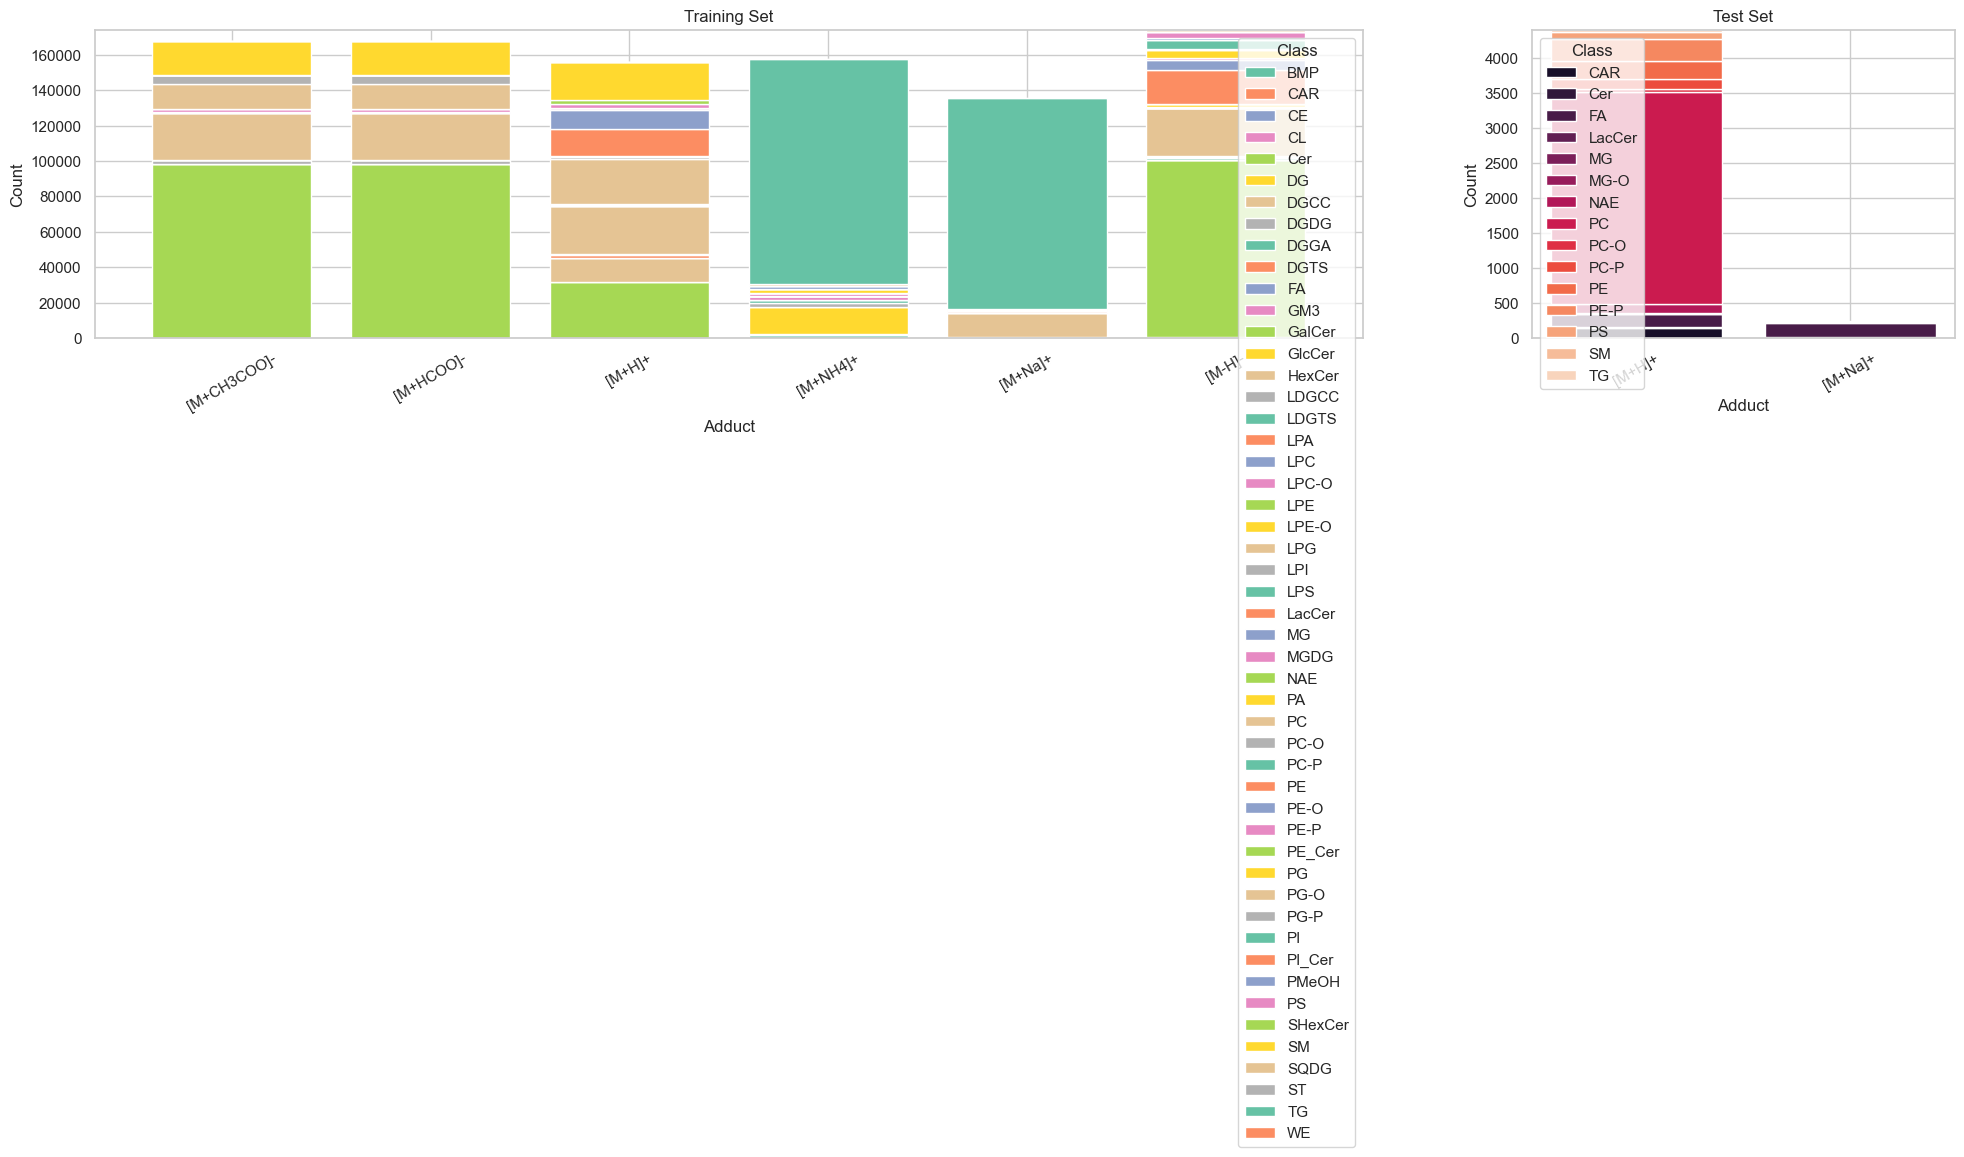

In [86]:
# Create pivot tables to summarize counts for each combination of adduct and class
train_counts = training_set.groupby(['adduct', 'class']).size().unstack(fill_value=0)
test_counts = test_set.groupby(['adduct', 'class']).size().unstack(fill_value=0)

# Get the unique classes for the training and test sets (will be used for color mapping)
classes_train = train_counts.columns.tolist()
classes_test = test_counts.columns.tolist()

# Define color palettes for each dataset based on the number of unique classes
train_palette = sns.color_palette("Set2", n_colors=len(classes_train))
test_palette = sns.color_palette("rocket", n_colors=len(classes_test))

# Map each class value to a color from the corresponding palette
color_map_train = dict(zip(classes_train, train_palette))
color_map_test = dict(zip(classes_test, test_palette))

# Create a figure with 2 subplots and set the left subplot's width to be larger than the right one
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 4),
                         gridspec_kw={'width_ratios': [3, 1]})

# --------------------------
# Plot for the Training Set
# --------------------------
adducts_train = train_counts.index.tolist()  # x-axis values: unique adducts
bottom = np.zeros(len(adducts_train))  # array to hold cumulative counts for stacking

# Loop over each class (color) and stack the bars
for cls in classes_train:
    values = train_counts[cls].values
    axes[0].bar(adducts_train, values, bottom=bottom,
                label=cls, color=color_map_train[cls])
    bottom += values

axes[0].set_title("Training Set")
axes[0].set_xlabel("Adduct")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=30)
axes[0].legend(title='Class')

# --------------------------
# Plot for the Test Set
# --------------------------
adducts_test = test_counts.index.tolist()  # x-axis values: unique adducts
bottom = np.zeros(len(adducts_test))  # reset cumulative counts for the test set

for cls in classes_test:
    values = test_counts[cls].values
    axes[1].bar(adducts_test, values, bottom=bottom,
                label=cls, color=color_map_test[cls])
    bottom += values

axes[1].set_title("Test Set")
axes[1].set_xlabel("Adduct")
axes[1].set_ylabel("Count")
axes[1].tick_params(axis='x', rotation=30)
axes[1].legend(title='Class')

# Adjust the layout for a clean display and render the plots
plt.tight_layout()
plt.show()

# Print the frequency counts as pivot tables for further review
# print("Training Set Frequency Count (Adduct x Class):")
# print(train_counts)

# print("\nTest Set Frequency Count (Adduct x Class):")
# print(test_counts)